<a href="https://colab.research.google.com/github/Han8000/gkstmddn/blob/main/yoloV8_%ED%95%9C%EA%B5%AD%EC%9D%B8_%EC%95%88%EB%A9%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics --upgrade -q
from ultralytics import YOLO
import torch

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.1/994.1 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.3 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ult

In [3]:
import os
from pathlib import Path
import shutil
import random
from PIL import Image
from tqdm import tqdm

root_dir = Path('/content/drive/MyDrive/face_dataset02')  # 원본 폴더
yolo_dir = Path('/content/drive/MyDrive/face_dataset02_yolo')  # YOLO용 폴더
split_ratio = [0.7, 0.2, 0.1]  # train, val, test 비율

# YOLO 디렉토리 구조 생성
for split in ['train', 'val', 'test']:
    (yolo_dir / split / 'images').mkdir(parents=True, exist_ok=True)
    (yolo_dir / split / 'labels').mkdir(parents=True, exist_ok=True)

# 이미지 크기 가져오기
def get_image_size(image_path):
    with Image.open(image_path) as img:
        return img.size

# txt 변환 및 저장
def convert_txt_and_copy(image_path, txt_path, save_img_path, save_txt_path):
    try:
        w, h = get_image_size(image_path)
        with open(txt_path, "r") as f:
            lines = f.readlines()
        if len(lines) < 8:
            print(f"❗ Skipping {txt_path} — not enough lines.")
            return

        keypoints = []
        for i in range(7):
            x, y = map(float, lines[i].strip().split())
            keypoints.append((x / w, y / h, 2))  # visibility = 2

        x_c, y_c, bw, bh = map(float, lines[7].strip().split())
        x_c /= w
        y_c /= h
        bw /= w
        bh /= h

        yolo_line = f"0 {x_c:.6f} {y_c:.6f} {bw:.6f} {bh:.6f} "
        for x, y, v in keypoints:
            yolo_line += f"{x:.6f} {y:.6f} {v} "
        yolo_line = yolo_line.strip()

        Image.open(image_path).save(save_img_path)
        with open(save_txt_path, "w") as f:
            f.write(yolo_line)
    except Exception as e:
        print(f"❌ Error processing {image_path.name}: {e}")

# 전체 데이터 수집
all_data = []
for person_dir in tqdm(list(root_dir.iterdir()), desc="📁 Scanning persons"):
    if person_dir.is_dir():
        for exp_dir in person_dir.iterdir():
            if exp_dir.is_dir():
                for file in exp_dir.glob("*.jpg"):
                    txt_file = file.with_suffix('.txt')
                    if txt_file.exists():
                        all_data.append((file, txt_file))

# 분할 및 저장
random.shuffle(all_data)
n = len(all_data)
train_data = all_data[:int(n * split_ratio[0])]
val_data = all_data[int(n * split_ratio[0]):int(n * (split_ratio[0] + split_ratio[1]))]
test_data = all_data[int(n * (split_ratio[0] + split_ratio[1])):]

splits = [('train', train_data), ('val', val_data), ('test', test_data)]
for split_name, data in splits:
    print(f"🔧 Processing {split_name} — 총 {len(data)}개")
    for img_path, txt_path in tqdm(data):
        base_name = img_path.stem
        save_img = yolo_dir / split_name / 'images' / f"{base_name}.jpg"
        save_txt = yolo_dir / split_name / 'labels' / f"{base_name}.txt"
        convert_txt_and_copy(img_path, txt_path, save_img, save_txt)

print("✅ 변환 완료. YOLOv8 학습 준비 끝!")


📁 Scanning persons: 100%|██████████| 24/24 [00:00<00:00, 103.84it/s]


🔧 Processing train — 총 1007개


100%|██████████| 1007/1007 [25:30<00:00,  1.52s/it]


🔧 Processing val — 총 288개


100%|██████████| 288/288 [06:58<00:00,  1.45s/it]


🔧 Processing test — 총 144개


100%|██████████| 144/144 [03:24<00:00,  1.42s/it]

✅ 변환 완료. YOLOv8 학습 준비 끝!


In [16]:
import os
from PIL import Image

# 🔧 개별 bbox 재계산 함수
def recalc_bbox_from_kpts(label_path, img_path):
    with open(label_path, 'r') as f:
        line = f.readline().strip().split()

    cls = int(line[0])
    box = list(map(float, line[1:5]))  # 이전 bbox (사용 X)
    kpts = list(map(float, line[5:]))

    img = Image.open(img_path)
    w, h = img.size

    # Keypoints 좌표 복원 (픽셀 단위)
    kpt_xy = []
    for i in range(0, len(kpts), 3):
        x, y, v = kpts[i] * w, kpts[i+1] * h, kpts[i+2]
        if v > 0:  # 보이는 점만 bbox 계산에 사용
            kpt_xy.append((x, y))

    if len(kpt_xy) == 0:
        print(f"[⚠️ 경고] {label_path} 에 visible keypoint가 없습니다.")
        return

    # bbox 계산
    x_coords = [x for x, y in kpt_xy]
    y_coords = [y for x, y in kpt_xy]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    # padding 추가
    margin = 0.15
    bw = (x_max - x_min) * (1 + margin)
    bh = (y_max - y_min) * (1 + margin)
    cx = (x_min + x_max) / 2
    cy = (y_min + y_max) / 2

    # 정규화
    norm_cx = cx / w
    norm_cy = cy / h
    norm_bw = bw / w
    norm_bh = bh / h

    # 라벨 덮어쓰기
    new_line = [str(cls), f"{norm_cx:.6f}", f"{norm_cy:.6f}", f"{norm_bw:.6f}", f"{norm_bh:.6f}"] + [f"{x:.6f}" for x in kpts]
    with open(label_path, 'w') as f:
        f.write(" ".join(new_line) + '\n')

    print(f"[✅ OK] {os.path.basename(label_path)} bbox 수정 완료")

# 🔁 전체 데이터셋 라벨 반복
def update_all_labels(base_path):
    for split in ['train', 'val', 'test']:
        label_dir = os.path.join(base_path, split, 'labels')
        image_dir = os.path.join(base_path, split, 'images')
        print(f"🔍 Processing {split} ...")
        for filename in os.listdir(label_dir):
            if filename.endswith('.txt'):
                label_path = os.path.join(label_dir, filename)
                img_path = os.path.join(image_dir, filename.replace('.txt', '.jpg'))
                if os.path.exists(img_path):
                    recalc_bbox_from_kpts(label_path, img_path)
                else:
                    print(f"[❌ 누락] 이미지가 없음: {img_path}")

# 🚀 실행
update_all_labels('/content/drive/MyDrive/face_dataset02_yolo')


🔍 Processing train ...
[✅ OK] C19.txt bbox 수정 완료
[✅ OK] C6.txt bbox 수정 완료
[✅ OK] C11.txt bbox 수정 완료
[✅ OK] C10.txt bbox 수정 완료
[✅ OK] C2.txt bbox 수정 완료
[✅ OK] C1.txt bbox 수정 완료
[✅ OK] C5.txt bbox 수정 완료
[✅ OK] C9.txt bbox 수정 완료
[✅ OK] C17.txt bbox 수정 완료
[✅ OK] C4.txt bbox 수정 완료
[✅ OK] C18.txt bbox 수정 완료
[✅ OK] C15.txt bbox 수정 완료
[✅ OK] C14.txt bbox 수정 완료
[✅ OK] C12.txt bbox 수정 완료
[✅ OK] C13.txt bbox 수정 완료
[✅ OK] C8.txt bbox 수정 완료
[✅ OK] C16.txt bbox 수정 완료
[✅ OK] C3.txt bbox 수정 완료
[✅ OK] C20.txt bbox 수정 완료
[✅ OK] C7.txt bbox 수정 완료
🔍 Processing val ...
[✅ OK] C8.txt bbox 수정 완료
[✅ OK] C9.txt bbox 수정 완료
[✅ OK] C19.txt bbox 수정 완료
[✅ OK] C11.txt bbox 수정 완료
[✅ OK] C17.txt bbox 수정 완료
[✅ OK] C5.txt bbox 수정 완료
[✅ OK] C1.txt bbox 수정 완료
[✅ OK] C18.txt bbox 수정 완료
[✅ OK] C10.txt bbox 수정 완료
[✅ OK] C15.txt bbox 수정 완료
[✅ OK] C20.txt bbox 수정 완료
[✅ OK] C4.txt bbox 수정 완료
[✅ OK] C7.txt bbox 수정 완료
[✅ OK] C16.txt bbox 수정 완료
[✅ OK] C6.txt bbox 수정 완료
[✅ OK] C3.txt bbox 수정 완료
[✅ OK] C14.txt bbox 수정 완료
[✅ OK] C13.

In [4]:
yaml_path = '/content/drive/MyDrive/face_dataset02_yolo/dataset.yaml'

with open(yaml_path, 'w') as f:
    f.write(f"""\
path: {yolo_dir}
train: train/images
val: val/images
test: test/images

names:
  0: face

kpt_shape: [7, 3]
""")

print(f"✅ dataset.yaml 생성 완료: {yaml_path}")


✅ dataset.yaml 생성 완료: /content/drive/MyDrive/face_dataset02_yolo/dataset.yaml


In [19]:
from ultralytics import YOLO

model = YOLO("yolov8n-pose.yaml")  # 또는 yolov8s-pose.yaml (데이터 많으면 s 추천)

model.train(
    data="/content/drive/MyDrive/face_dataset02_yolo/dataset.yaml",  # ← YAML 경로
    epochs=100,
    imgsz=640,            # 이미지 크기 (Roboflow랑 맞추는 게 좋음)
    batch=16,             # 배치 사이즈 (GPU 메모리 맞게 조절)
    device=0,             # GPU 0번 사용
    workers=2,            # DataLoader 병렬 처리 수
    name="face_kpt_train",# 실험 이름 (폴더에 저장됨)
    save=True,            # 모델 저장
    save_period=10,       # 10 에폭마다 저장
    val=True,             # 매 epoch마다 validation
    verbose=True,         # 로그 자세히 보기
    lr0=0.001,            # 초기 learning rate
    optimizer="Adam",      # Adam 쓸 수도 있음
)

Ultralytics 8.3.104 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.yaml, data=/content/drive/MyDrive/face_dataset02_yolo/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=2, project=None, name=face_kpt_train3, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, 

train: Scanning /content/drive/MyDrive/face_dataset02_yolo/train/labels... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 276.54it/s]

train: New cache created: /content/drive/MyDrive/face_dataset02_yolo/train/labels.cache
WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/face_dataset02_yolo/val/labels... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 219.07it/s]

val: New cache created: /content/drive/MyDrive/face_dataset02_yolo/val/labels.cache


Plotting labels to runs/pose/face_kpt_train3/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/pose/face_kpt_train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/100       2.3G      3.968      8.583      0.721      4.995      4.235          5        640: 100%|██████████| 2/2 [00:00<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.3G      3.799      7.903     0.7191      4.633      4.186          7        640: 100%|██████████| 2/2 [00:00<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


                   all         20         20          0          0          0          0          0          0          0          0

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/100       2.3G      3.359      8.808     0.7345      4.781      4.275          6        640: 100%|██████████| 2/2 [00:00<00:00,  5.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.57it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/100       2.3G       3.99      8.153      0.709      4.442       4.22         12        640: 100%|██████████| 2/2 [00:00<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.3G      3.394       8.22     0.6882      4.096      4.105          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/100       2.3G      2.932      7.847     0.6868      4.168      3.997          8        640: 100%|██████████| 2/2 [00:00<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/100       2.3G      3.596      7.106     0.6864      4.353      4.165          8        640: 100%|██████████| 2/2 [00:00<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/100       2.3G      3.412      7.179     0.6137      3.811       3.89         11        640: 100%|██████████| 2/2 [00:00<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.93it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/100       2.3G      2.819      6.938     0.5391      3.769       3.62          7        640: 100%|██████████| 2/2 [00:00<00:00,  9.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/100       2.3G      3.005      6.872     0.5969      3.343      3.627         10        640: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/100       2.3G      3.197      7.527      0.628      3.478      3.666          8        640: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/100       2.3G      3.084      6.664     0.5992      3.403      3.677          5        640: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/100       2.3G       3.26      6.634     0.5191       3.32      3.537          9        640: 100%|██████████| 2/2 [00:00<00:00,  9.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/100       2.3G      3.258       6.46     0.5302       3.01      3.554         10        640: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.07it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/100       2.3G      2.933      7.019      0.537      3.094      3.439          9        640: 100%|██████████| 2/2 [00:00<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.70it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/100       2.3G      2.412       7.33     0.6149      3.152      3.143          9        640: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.68it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/100       2.3G      2.721      6.185     0.4139      3.088      3.306          8        640: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.03it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/100       2.3G      3.053      6.735     0.5588      3.079      3.358          8        640: 100%|██████████| 2/2 [00:00<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.09it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/100       2.3G      2.548      6.805     0.6004      2.996      3.284          6        640: 100%|██████████| 2/2 [00:00<00:00,  9.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.60it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/100       2.3G      2.741      7.247     0.4641      2.925      3.043          6        640: 100%|██████████| 2/2 [00:00<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.18it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/100       2.3G      2.561      6.391     0.5416      2.895      3.064          7        640: 100%|██████████| 2/2 [00:00<00:00,  9.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.97it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/100       2.3G       2.47      6.806     0.4093      2.698      2.984          4        640: 100%|██████████| 2/2 [00:00<00:00, 10.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.62it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/100       2.3G       2.74      6.845      0.566      2.906      3.094          6        640: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.27it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/100       2.3G      2.692      6.273     0.3879      2.585       2.94          8        640: 100%|██████████| 2/2 [00:00<00:00,  9.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.55it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/100       2.3G      2.893      6.177     0.3986      2.781      3.044          8        640: 100%|██████████| 2/2 [00:00<00:00, 10.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.57it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/100       2.3G      2.598      6.075     0.3517      2.319      2.938          8        640: 100%|██████████| 2/2 [00:00<00:00,  9.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/100       2.3G      2.772      5.998     0.5962      2.533      2.997         13        640: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.06it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/100       2.3G      2.432      6.199     0.4558      2.311      2.772         10        640: 100%|██████████| 2/2 [00:00<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.87it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/100       2.3G      2.782      6.478     0.6396      2.446      2.947         12        640: 100%|██████████| 2/2 [00:00<00:00,  9.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.38it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/100       2.3G      2.688      6.822     0.5973      2.486      2.898         10        640: 100%|██████████| 2/2 [00:00<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.86it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/100       2.3G      2.794      6.224     0.4096       2.97      2.959          5        640: 100%|██████████| 2/2 [00:00<00:00, 11.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/100       2.3G      2.798      5.916     0.4261      2.736      2.998          6        640: 100%|██████████| 2/2 [00:00<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.21it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/100       2.3G      2.802      5.893     0.5494      2.764      2.976          6        640: 100%|██████████| 2/2 [00:00<00:00, 10.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.57it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/100       2.3G        2.6      6.128     0.6413      2.367      2.789          7        640: 100%|██████████| 2/2 [00:00<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.36it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/100       2.3G      2.772      5.212     0.3869      2.254      2.853         10        640: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.24it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/100       2.3G      2.938      6.144      0.779      2.492      3.105          5        640: 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.55it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/100       2.3G      2.764      5.808      0.514      2.381       2.81          8        640: 100%|██████████| 2/2 [00:00<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.24it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/100       2.3G      2.348      5.022     0.3852      2.451      2.638          4        640: 100%|██████████| 2/2 [00:00<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.83it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/100       2.3G      2.701      5.007     0.5821      2.573      2.951          4        640: 100%|██████████| 2/2 [00:00<00:00,  9.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.62it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/100       2.3G       3.11      5.832     0.6212      2.369      3.119          8        640: 100%|██████████| 2/2 [00:00<00:00, 10.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.64it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/100       2.3G      2.546      5.189      0.301      2.418      2.807          7        640: 100%|██████████| 2/2 [00:00<00:00, 10.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/100       2.3G      2.529      5.103     0.4209      2.084      2.786         10        640: 100%|██████████| 2/2 [00:00<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.44it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/100       2.3G      2.735      5.144     0.5772       2.23      2.965          7        640: 100%|██████████| 2/2 [00:00<00:00,  9.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.63it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/100       2.3G       2.52      5.396     0.5166      2.356       2.76          7        640: 100%|██████████| 2/2 [00:00<00:00,  9.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.61it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/100       2.3G      2.502      5.292     0.4902      2.076        2.7          8        640: 100%|██████████| 2/2 [00:00<00:00, 11.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.73it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/100       2.3G      2.427      4.765     0.3799      2.029      2.623          9        640: 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.37it/s]

                   all         20         20     0.0505       0.25     0.0359     0.0112          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/100       2.3G      2.469      5.613     0.6842      2.097      2.743          9        640: 100%|██████████| 2/2 [00:00<00:00, 11.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.02it/s]

                   all         20         20     0.0505       0.25     0.0359     0.0112          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/100       2.3G      2.418       5.44     0.5006      1.959       2.71         12        640: 100%|██████████| 2/2 [00:00<00:00,  9.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all         20         20     0.0339       0.65     0.0383     0.0128          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/100       2.3G      2.383      5.252     0.4981      2.229      2.632          4        640: 100%|██████████| 2/2 [00:00<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         20         20     0.0339       0.65     0.0383     0.0128          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/100       2.3G      2.438      5.186     0.6284       2.08      2.602          9        640: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         20         20     0.0326       0.75     0.0413     0.0141     0.0109       0.25    0.00781    0.00104



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/100       2.3G      2.425      4.786     0.5234      2.042      2.666          6        640: 100%|██████████| 2/2 [00:00<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         20         20     0.0326       0.75     0.0413     0.0141     0.0109       0.25    0.00781    0.00104



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/100       2.3G      2.381      4.907      0.556      1.896       2.61          9        640: 100%|██████████| 2/2 [00:00<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         20         20     0.0278       0.85     0.0425     0.0138    0.00982        0.3    0.00926    0.00127



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.3G      2.511      5.328       0.53      2.128       2.66          9        640: 100%|██████████| 2/2 [00:00<00:00, 11.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         20         20     0.0278       0.85     0.0425     0.0138    0.00982        0.3    0.00926    0.00127



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/100       2.3G      2.403      4.841     0.5224      1.996      2.612         12        640: 100%|██████████| 2/2 [00:00<00:00, 10.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         20         20     0.0222       0.85     0.0416     0.0142     0.0104        0.4     0.0163    0.00362



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/100       2.3G      2.448      4.182     0.5292      2.102      2.717          4        640: 100%|██████████| 2/2 [00:00<00:00, 11.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.90it/s]

                   all         20         20     0.0222       0.85     0.0416     0.0142     0.0104        0.4     0.0163    0.00362



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.3G      2.303      5.152      0.466      2.035      2.634         11        640: 100%|██████████| 2/2 [00:00<00:00, 10.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

                   all         20         20     0.0181       0.85     0.0457      0.016     0.0085        0.4     0.0183    0.00502



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/100       2.3G      2.752      5.586     0.6793      2.434       2.86          9        640: 100%|██████████| 2/2 [00:00<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.45it/s]

                   all         20         20     0.0181       0.85     0.0457      0.016     0.0085        0.4     0.0183    0.00502



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/100       2.3G      2.656      5.285     0.3148      1.971      2.946          3        640: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.65it/s]

                   all         20         20      0.019        0.8     0.0919     0.0295     0.0095        0.4     0.0288    0.00475



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/100       2.3G      2.153      4.681     0.4101       1.81      2.543          6        640: 100%|██████████| 2/2 [00:00<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

                   all         20         20      0.019        0.8     0.0919     0.0295     0.0095        0.4     0.0288    0.00475



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/100       2.3G      2.698      4.407     0.5664      2.049      2.892         12        640: 100%|██████████| 2/2 [00:00<00:00, 10.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         20         20     0.0182        0.8      0.139     0.0413    0.00912        0.4     0.0204    0.00411



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/100       2.3G      2.273      4.696      0.418        1.7      2.603         12        640: 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         20         20     0.0182        0.8      0.139     0.0413    0.00912        0.4     0.0204    0.00411



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/100       2.3G      2.304      4.967     0.5038      1.743      2.622          6        640: 100%|██████████| 2/2 [00:00<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.71it/s]

                   all         20         20     0.0205       0.85       0.22     0.0845     0.0133       0.55      0.107     0.0233



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/100       2.3G      2.362      4.785     0.4754      1.808      2.575          6        640: 100%|██████████| 2/2 [00:00<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         20         20     0.0205       0.85       0.22     0.0845     0.0133       0.55      0.107     0.0233



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/100       2.3G      2.335       4.25     0.3479      1.942      2.631          5        640: 100%|██████████| 2/2 [00:00<00:00, 10.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]

                   all         20         20     0.0271       0.85      0.212     0.0802     0.0159        0.5      0.111      0.023



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/100       2.3G      2.452      5.218     0.6113      1.867       2.66          7        640: 100%|██████████| 2/2 [00:00<00:00, 11.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         20         20     0.0271       0.85      0.212     0.0802     0.0159        0.5      0.111      0.023



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/100       2.3G      2.445      4.394     0.3525      1.722       2.58         10        640: 100%|██████████| 2/2 [00:00<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]

                   all         20         20     0.0256        0.8      0.285     0.0837     0.0144       0.45     0.0646      0.018



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/100       2.3G      2.264      4.338     0.3673      2.048      2.519          7        640: 100%|██████████| 2/2 [00:00<00:00, 11.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         20         20     0.0256        0.8      0.285     0.0837     0.0144       0.45     0.0646      0.018



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/100       2.3G      2.239      5.057      0.472      1.999      2.583          4        640: 100%|██████████| 2/2 [00:00<00:00,  9.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         20         20     0.0957       0.85      0.297     0.0776      0.045        0.4     0.0945     0.0253



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/100       2.3G      2.488      4.662     0.4801      1.803      2.796          8        640: 100%|██████████| 2/2 [00:00<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         20         20     0.0957       0.85      0.297     0.0776      0.045        0.4     0.0945     0.0253



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/100       2.3G      2.529      5.646     0.6342      1.891      2.798          8        640: 100%|██████████| 2/2 [00:00<00:00, 10.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         20         20      0.413       0.45      0.342     0.0938      0.197       0.25      0.133     0.0245



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/100       2.3G      2.067      4.709     0.4808      1.792      2.424         10        640: 100%|██████████| 2/2 [00:00<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

                   all         20         20      0.413       0.45      0.342     0.0938      0.197       0.25      0.133     0.0245



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/100       2.3G      2.318       4.56     0.5876      1.755      2.662          8        640: 100%|██████████| 2/2 [00:00<00:00,  9.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

                   all         20         20      0.407        0.5      0.364      0.122      0.128       0.25      0.065     0.0141



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/100       2.3G       2.47      4.153     0.6084      1.875      2.611          8        640: 100%|██████████| 2/2 [00:00<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         20         20      0.407        0.5      0.364      0.122      0.128       0.25      0.065     0.0141



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/100       2.3G      2.245      4.516     0.4742      1.684      2.532          8        640: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         20         20      0.416        0.3      0.418      0.156      0.167        0.2     0.0891     0.0171



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/100       2.3G      2.617      4.734     0.6203       1.79      2.786          6        640: 100%|██████████| 2/2 [00:00<00:00, 10.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]

                   all         20         20      0.416        0.3      0.418      0.156      0.167        0.2     0.0891     0.0171



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/100       2.3G      2.403      4.691      0.527      1.693      2.625         10        640: 100%|██████████| 2/2 [00:00<00:00,  9.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all         20         20      0.732        0.3      0.399      0.147      0.195        0.3       0.12     0.0259



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/100       2.3G      2.298      4.447      0.427      1.748       2.61          6        640: 100%|██████████| 2/2 [00:00<00:00, 11.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

                   all         20         20      0.732        0.3      0.399      0.147      0.195        0.3       0.12     0.0259



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/100       2.3G       2.07      4.383     0.3509      1.743      2.406         11        640: 100%|██████████| 2/2 [00:00<00:00,  9.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         20         20       0.37        0.3      0.369      0.108      0.187       0.15        0.1     0.0268



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/100       2.3G      2.223      4.582     0.4317       1.72      2.514          8        640: 100%|██████████| 2/2 [00:00<00:00, 11.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

                   all         20         20       0.37        0.3      0.369      0.108      0.187       0.15        0.1     0.0268



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/100       2.3G      2.778      4.094     0.8905      1.815      2.935          5        640: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.69it/s]

                   all         20         20      0.412      0.211      0.326     0.0861      0.294       0.15      0.148     0.0276



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/100       2.3G      2.285      4.393     0.5607      1.576      2.642          8        640: 100%|██████████| 2/2 [00:00<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         20         20      0.412      0.211      0.326     0.0861      0.294       0.15      0.148     0.0276



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/100       2.3G      2.221      5.055     0.6293      1.668       2.56         11        640: 100%|██████████| 2/2 [00:00<00:00,  9.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.78it/s]

                   all         20         20      0.555        0.2      0.343     0.0872      0.413       0.15      0.177     0.0281



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/100       2.3G      2.313      4.667     0.5263      1.681      2.609          5        640: 100%|██████████| 2/2 [00:00<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.44it/s]

                   all         20         20      0.555        0.2      0.343     0.0872      0.413       0.15      0.177     0.0281



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/100       2.3G      2.013      4.011     0.3842      1.863      2.385          5        640: 100%|██████████| 2/2 [00:00<00:00, 10.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all         20         20      0.823        0.2      0.374      0.111      0.449       0.15       0.19     0.0337



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/100       2.3G      2.227      4.546     0.6587      1.581      2.592          7        640: 100%|██████████| 2/2 [00:00<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         20         20      0.823        0.2      0.374      0.111      0.449       0.15       0.19     0.0337



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/100       2.3G      2.374      4.626     0.6192      1.692      2.624          9        640: 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         20         20      0.844       0.25       0.44      0.147      0.458        0.2      0.249     0.0488



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/100       2.3G      2.039      3.872     0.4374       1.63      2.362          6        640: 100%|██████████| 2/2 [00:00<00:00, 12.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         20         20      0.844       0.25       0.44      0.147      0.458        0.2      0.249     0.0488



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/100       2.3G      2.365      4.093     0.4773      1.699      2.505         12        640: 100%|██████████| 2/2 [00:00<00:00,  9.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         20         20      0.577        0.3        0.5      0.179      0.622        0.3      0.436     0.0787



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/100       2.3G      2.857      5.125     0.6626      1.788       3.09          5        640: 100%|██████████| 2/2 [00:00<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         20         20      0.577        0.3        0.5      0.179      0.622        0.3      0.436     0.0787



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/100       2.3G      2.119      4.289     0.4193      1.468      2.343          8        640: 100%|██████████| 2/2 [00:00<00:00,  9.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]

                   all         20         20      0.533      0.457       0.54      0.198      0.483        0.4       0.47     0.0987


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/100       2.3G      2.074      3.524     0.2271      1.726      2.473          4        640: 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all         20         20      0.533      0.457       0.54      0.198      0.483        0.4       0.47     0.0987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/100       2.3G       1.93      3.534     0.2515      1.822      2.432          4        640: 100%|██████████| 2/2 [00:00<00:00,  8.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         20         20      0.546       0.45      0.582      0.206      0.394      0.424      0.459      0.102



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/100       2.3G       1.82      3.819     0.2851      1.827      2.385          4        640: 100%|██████████| 2/2 [00:00<00:00, 11.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         20         20      0.546       0.45      0.582      0.206      0.394      0.424      0.459      0.102



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/100       2.3G      1.904      3.492     0.2459      1.684      2.453          4        640: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all         20         20      0.566      0.587      0.581      0.203       0.45       0.55      0.487      0.123



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/100       2.3G      1.989      3.268     0.2394      1.619       2.51          4        640: 100%|██████████| 2/2 [00:00<00:00, 11.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         20         20      0.566      0.587      0.581      0.203       0.45       0.55      0.487      0.123



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/100       2.3G      1.838      3.509     0.2369      1.683      2.487          4        640: 100%|██████████| 2/2 [00:00<00:00,  8.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

                   all         20         20      0.534      0.574      0.584      0.189      0.406       0.55      0.491      0.123



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/100       2.3G      2.055      3.407     0.2309      1.753      2.424          4        640: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         20         20      0.534      0.574      0.584      0.189      0.406       0.55      0.491      0.123



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/100       2.3G      1.872       3.43     0.2056      1.661      2.493          4        640: 100%|██████████| 2/2 [00:00<00:00, 10.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

                   all         20         20      0.534      0.515      0.576      0.183      0.518       0.55      0.464      0.112



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/100       2.3G      1.779      3.662     0.2247      1.411      2.299          4        640: 100%|██████████| 2/2 [00:00<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         20         20      0.534      0.515      0.576      0.183      0.518       0.55      0.464      0.112



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/100       2.3G      1.918      3.645     0.2583      1.596      2.509          4        640: 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

                   all         20         20      0.522        0.5      0.577      0.194       0.48      0.509      0.448      0.116



100 epochs completed in 0.019 hours.
Optimizer stripped from runs/pose/face_kpt_train3/weights/last.pt, 6.5MB
Optimizer stripped from runs/pose/face_kpt_train3/weights/best.pt, 6.5MB

Validating runs/pose/face_kpt_train3/weights/best.pt...
Ultralytics 8.3.104 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv8n-pose summary (fused): 81 layers, 3,103,934 parameters, 0 gradients, 8.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]


                   all         20         20      0.571      0.599      0.581      0.203      0.452       0.55      0.486      0.123
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/pose/face_kpt_train3


ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7af685cb1c10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    


image 1/1 /content/drive/MyDrive/face_dataset02_yolo/val/images/C1.jpg: 448x640 1 face, 10.6ms
Speed: 2.4ms preprocess, 10.6ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


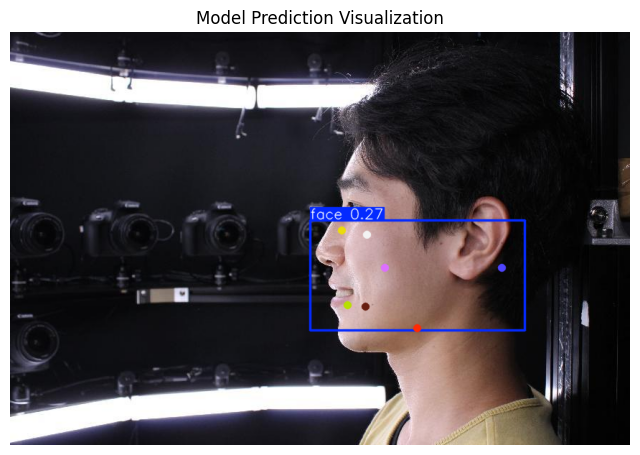

In [21]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt

# 모델 로드
model = YOLO('runs/pose/face_kpt_train3/weights/best.pt')

# 예측
img_path = '/content/drive/MyDrive/face_dataset02_yolo/val/images/C1.jpg'
results = model(img_path, save=False, conf=0.25)

# 시각화
annotated = results[0].plot()
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Model Prediction Visualization")
plt.show()


In [22]:
with open('/content/drive/MyDrive/face_dataset02_yolo/val/labels/C1.txt', 'r') as f:
    print(f.read())


0 0.631945 0.532986 0.311458 0.239584 0.496528 0.543403 2.000000 0.541667 0.439236 2.000000 0.554398 0.428819 2.000000 0.539352 0.637153 2.000000 0.553241 0.635417 2.000000 0.660880 0.517361 2.000000 0.767361 0.498264 2.000000



In [23]:
#v 값을 2 → 1로 바꾸는 코드 (전체 수정)
import os

def fix_visibility_in_labels(label_dir):
    for filename in os.listdir(label_dir):
        if not filename.endswith(".txt"):
            continue
        path = os.path.join(label_dir, filename)
        with open(path, 'r') as f:
            line = f.readline().strip().split()

        # 수정된 v 값 적용
        for i in range(5, len(line), 3):
            if line[i+2] == '2':
                line[i+2] = '1'

        # 다시 저장
        with open(path, 'w') as f:
            f.write(' '.join(line) + '\n')
        print(f"[수정 완료] {filename}")

# 예시 경로
fix_visibility_in_labels('/content/drive/MyDrive/face_dataset02_yolo/train/labels')
fix_visibility_in_labels('/content/drive/MyDrive/face_dataset02_yolo/val/labels')
fix_visibility_in_labels('/content/drive/MyDrive/face_dataset02_yolo/test/labels')


[수정 완료] C19.txt
[수정 완료] C6.txt
[수정 완료] C11.txt
[수정 완료] C10.txt
[수정 완료] C2.txt
[수정 완료] C1.txt
[수정 완료] C5.txt
[수정 완료] C9.txt
[수정 완료] C17.txt
[수정 완료] C4.txt
[수정 완료] C18.txt
[수정 완료] C15.txt
[수정 완료] C14.txt
[수정 완료] C12.txt
[수정 완료] C13.txt
[수정 완료] C8.txt
[수정 완료] C16.txt
[수정 완료] C3.txt
[수정 완료] C20.txt
[수정 완료] C7.txt
[수정 완료] C8.txt
[수정 완료] C9.txt
[수정 완료] C19.txt
[수정 완료] C11.txt
[수정 완료] C17.txt
[수정 완료] C5.txt
[수정 완료] C1.txt
[수정 완료] C18.txt
[수정 완료] C10.txt
[수정 완료] C15.txt
[수정 완료] C20.txt
[수정 완료] C4.txt
[수정 완료] C7.txt
[수정 완료] C16.txt
[수정 완료] C6.txt
[수정 완료] C3.txt
[수정 완료] C14.txt
[수정 완료] C13.txt
[수정 완료] C12.txt
[수정 완료] C2.txt
[수정 완료] C8.txt
[수정 완료] C2.txt
[수정 완료] C7.txt
[수정 완료] C6.txt
[수정 완료] C1.txt
[수정 완료] C9.txt
[수정 완료] C10.txt
[수정 완료] C4.txt
[수정 완료] C11.txt
[수정 완료] C13.txt
[수정 완료] C5.txt
[수정 완료] C14.txt
[수정 완료] C3.txt
[수정 완료] C17.txt
[수정 완료] C18.txt
[수정 완료] C12.txt
[수정 완료] C15.txt
[수정 완료] C16.txt
[수정 완료] C19.txt
[수정 완료] C20.txt


In [38]:
import os

def expand_yolov8_keypoint_line(line, scale=1.6):
    parts = line.strip().split()
    if len(parts) < 5:
        return line
    class_id = parts[0]
    xc, yc, w, h = map(float, parts[1:5])
    keypoints = parts[5:]

    new_w = min(w * scale, 1.0)
    new_h = min(h * scale, 1.0)

    return f"{class_id} {xc:.6f} {yc:.6f} {new_w:.6f} {new_h:.6f} " + " ".join(keypoints)

def process_folder(label_dir, scale=1.5):
    for filename in os.listdir(label_dir):
        if filename.endswith(".txt"):
            path = os.path.join(label_dir, filename)
            with open(path, "r") as f:
                lines = f.readlines()
            new_lines = [expand_yolov8_keypoint_line(line, scale) for line in lines]
            with open(path, "w") as f:
                f.write("\n".join(new_lines))

# 세 개 폴더 한 번에 처리
for sub in ["train", "val", "test"]:
    label_path = f"/content/drive/MyDrive/face_dataset02_yolo/{sub}/labels"
    process_folder(label_path, scale=1.5)
    print(f"✅ {sub} done!")


✅ train done!
✅ val done!
✅ test done!


In [45]:
from ultralytics import YOLO

model = YOLO("yolov8s-pose.yaml")  # s 모델로 변경 (정확도 개선 목적)

model.train(
    data="/content/drive/MyDrive/face_dataset02_yolo/dataset.yaml",  # ← YAML 경로
    epochs=200,                  # 학습 기간 늘림
    imgsz=640,
    batch=16,
    device=0,
    workers=2,
    name="face_kpt_train_v2",
    save=True,
    save_period=10,
    val=True,
    verbose=True,
    optimizer="SGD",             # 변경됨
    lr0=0.005,                   # 초기 learning rate 조정
    lrf=0.01,                    # 최종 learning rate
    warmup_epochs=5,            # 워밍업
    weight_decay=0.0001,        # 가중치 감소
    close_mosaic=5,             # 모자이크 종료 시점
    seed=42,                    # 재현성
    deterministic=True,        # 재현성
    plots=True,                 # 학습 로그 그래프 저장
)


Ultralytics 8.3.104 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=pose, mode=train, model=yolov8s-pose.yaml, data=/content/drive/MyDrive/face_dataset02_yolo/dataset.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=2, project=None, name=face_kpt_train_v22, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=5, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False

train: Scanning /content/drive/MyDrive/face_dataset02_yolo/train/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/face_dataset02_yolo/val/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]


Plotting labels to runs/pose/face_kpt_train_v22/labels.jpg... 
optimizer: SGD(lr=0.005, momentum=0.937) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0001), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/pose/face_kpt_train_v22
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/200       3.7G      4.086      8.211     0.7009      5.749      4.209          5        640: 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/200       3.7G      3.815      8.115     0.6898      5.067      4.177          7        640: 100%|██████████| 2/2 [00:00<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


                   all         20         20          0          0          0          0          0          0          0          0

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/200       3.7G       3.34      8.889     0.6965      5.474      4.216          6        640: 100%|██████████| 2/2 [00:00<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/200       3.7G      4.204      8.529     0.6981      5.126      4.186         12        640: 100%|██████████| 2/2 [00:00<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/200       3.7G      3.938      8.541     0.7044       4.86       4.21          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/200       3.7G      3.816      8.725     0.7212      5.314      4.218          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/200       3.7G      4.298      8.021     0.7177      5.398      4.244          8        640: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/200       3.7G      4.192      8.396     0.7068       4.98        4.2         11        640: 100%|██████████| 2/2 [00:00<00:00,  6.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/200       3.7G      3.996      8.669     0.6605      4.762      4.176          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/200       3.7G      3.922      8.508     0.6892      4.477      4.178         10        640: 100%|██████████| 2/2 [00:00<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/200       3.7G      4.081      8.829      0.689      4.845      4.168          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/200      3.71G      3.514      8.473     0.6815      4.818      4.154          5        640: 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/200      3.71G      4.251      8.118     0.6874      4.525       4.18          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/200      3.71G      4.247       8.47     0.6902      4.473      4.174         10        640: 100%|██████████| 2/2 [00:00<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/200      3.71G      3.752      8.422     0.6928      4.449      4.147          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/200      3.73G      3.771      7.701      0.692      4.356      4.135          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/200      3.73G      3.605      8.232     0.6729      4.343       4.14          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/200      3.73G      3.889      8.053     0.6771      4.446      4.128          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/200      3.73G      3.252       8.19     0.6898      4.542      4.141          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.76G      3.729      8.723     0.7052      4.559      4.137          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/200      3.76G      3.422      8.192     0.6874      4.215      4.116          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/200      3.76G      3.503      8.747     0.6843      4.447      4.077          4        640: 100%|██████████| 2/2 [00:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/200      3.76G      3.467      8.197     0.6863      4.214      4.133          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/200      3.79G      3.757      8.413     0.6695      4.142      4.087          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/200      3.79G      3.735      7.769      0.661      4.035      4.087          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/200      3.79G       3.52      7.962     0.6546      3.613      4.056          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/200       3.8G      3.857        7.5     0.6702      3.724      4.086         13        640: 100%|██████████| 2/2 [00:00<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/200      3.82G      3.198      7.877     0.6705      3.357      4.044         10        640: 100%|██████████| 2/2 [00:00<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/200      3.82G      4.017      7.781     0.6835      3.458      4.048         12        640: 100%|██████████| 2/2 [00:00<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/200      3.82G      3.595      7.379     0.6669      3.559      4.055         10        640: 100%|██████████| 2/2 [00:00<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.32it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/200      3.82G      3.856      7.808     0.6454      4.053      4.076          5        640: 100%|██████████| 2/2 [00:00<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/200      3.82G      3.312      7.622     0.6553      3.725      4.135          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/200      3.82G      3.085      7.018     0.6462       3.64       4.07          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/200      3.82G      3.768      6.889     0.6512      3.706      4.002          7        640: 100%|██████████| 2/2 [00:00<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/200      3.82G      3.356      6.648     0.6035      2.838      3.977         10        640: 100%|██████████| 2/2 [00:00<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/200      3.82G      3.681      6.569      0.713      3.729      4.043          5        640: 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/200      3.82G      3.291      6.618     0.6396      3.282      3.976          8        640: 100%|██████████| 2/2 [00:00<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/200      3.82G      3.231      6.281     0.6057      3.481      4.018          4        640: 100%|██████████| 2/2 [00:00<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/200      3.82G      2.706      5.691     0.6439      3.477      3.992          4        640: 100%|██████████| 2/2 [00:00<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/200      3.82G      3.482      6.292     0.6427      3.484      3.978          8        640: 100%|██████████| 2/2 [00:00<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/200      3.82G      3.017      6.762     0.5639      2.991      3.907          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/200      3.82G      2.989      6.548     0.5838      2.818      3.903         10        640: 100%|██████████| 2/2 [00:00<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/200      3.82G      2.682      5.211     0.6174      2.943      3.935          7        640: 100%|██████████| 2/2 [00:00<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/200      3.82G       2.96      7.007     0.6121       3.36      3.902          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.86it/s]

                   all         20         20    0.00334       0.95    0.00327   0.000711          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/200      3.82G      3.563      6.268     0.5738       3.21      3.861          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20         20    0.00334       0.95    0.00327   0.000711          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/200      3.82G      2.941      5.939     0.5743      2.979      3.799          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all         20         20     0.0032       0.95    0.00331   0.000814          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/200      3.82G      2.957      6.402     0.6463      2.864      3.837          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

                   all         20         20     0.0032       0.95    0.00331   0.000814          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/200      3.82G      3.383      6.304     0.5606      2.736      3.904         12        640: 100%|██████████| 2/2 [00:00<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         20         20    0.00333          1     0.0115    0.00321   0.000333        0.1   0.000294   2.94e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/200      3.82G      3.364      6.743     0.5532       3.93      3.945          4        640: 100%|██████████| 2/2 [00:00<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]

                   all         20         20    0.00333          1     0.0115    0.00321   0.000333        0.1   0.000294   2.94e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/200      3.82G      2.869      6.359     0.5997      3.117      3.739          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         20         20    0.00333          1      0.013    0.00406     0.0005       0.15   0.000541   6.61e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/200      3.82G      3.143      6.086     0.5727      3.127      3.789          6        640: 100%|██████████| 2/2 [00:00<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

                   all         20         20    0.00333          1      0.013    0.00406     0.0005       0.15   0.000541   6.61e-05



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/200      3.82G      2.825      6.007     0.5656      2.838      3.739          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         20         20    0.00333          1      0.152     0.0568    0.00267        0.8     0.0298    0.00541



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/200      3.82G      3.106      5.974     0.5555       2.82      3.682          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         20         20    0.00333          1      0.152     0.0568    0.00267        0.8     0.0298    0.00541



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/200      3.82G      2.785      5.303     0.5701      2.618      3.665         12        640: 100%|██████████| 2/2 [00:00<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

                   all         20         20    0.00333          1      0.224     0.0712    0.00283       0.85     0.0173    0.00243



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/200      3.82G      3.061      5.262     0.5631      4.009      3.878          4        640: 100%|██████████| 2/2 [00:00<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         20         20    0.00333          1      0.224     0.0712    0.00283       0.85     0.0173    0.00243



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/200      3.82G       2.79      5.914     0.5386      2.587      3.663         11        640: 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         20         20    0.00333          1      0.373      0.129    0.00283       0.85      0.102     0.0218



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/200      3.82G      2.861      6.631      0.622      3.014      3.658          9        640: 100%|██████████| 2/2 [00:00<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         20         20    0.00333          1      0.373      0.129    0.00283       0.85      0.102     0.0218



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/200      3.82G      3.177      6.172     0.4882      3.362      3.893          3        640: 100%|██████████| 2/2 [00:00<00:00,  7.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

                   all         20         20    0.00333          1      0.521      0.171    0.00233        0.7       0.15     0.0459



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/200      3.82G      2.166      5.664     0.4922      2.705      3.574          6        640: 100%|██████████| 2/2 [00:00<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         20         20    0.00333          1      0.521      0.171    0.00233        0.7       0.15     0.0459



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/200      3.82G      2.899       5.27     0.5591        2.8      3.673         12        640: 100%|██████████| 2/2 [00:00<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         20         20      0.217        0.7        0.3      0.125     0.0476       0.25     0.0413    0.00869



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/200      3.82G      2.613      5.507     0.5366       2.41      3.491         12        640: 100%|██████████| 2/2 [00:00<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]

                   all         20         20      0.217        0.7        0.3      0.125     0.0476       0.25     0.0413    0.00869



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/200      3.82G      2.316      5.434     0.5385       2.74      3.548          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]

                   all         20         20      0.264        0.5      0.415      0.172     0.0681       0.25     0.0515     0.0109



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/200      3.82G      2.702        5.6     0.5248      2.955      3.646          6        640: 100%|██████████| 2/2 [00:00<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         20         20      0.264        0.5      0.415      0.172     0.0681       0.25     0.0515     0.0109



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/200      3.82G      2.685      5.425      0.462      2.883       3.69          5        640: 100%|██████████| 2/2 [00:00<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]

                   all         20         20     0.0929        0.9      0.486      0.199     0.0361       0.35      0.114     0.0332



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/200      3.82G      2.843      5.977     0.6096      2.988      3.888          7        640: 100%|██████████| 2/2 [00:00<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         20         20     0.0929        0.9      0.486      0.199     0.0361       0.35      0.114     0.0332



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/200      3.82G      2.752      4.767     0.4831      2.576      3.612         10        640: 100%|██████████| 2/2 [00:00<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         20         20      0.454      0.376      0.437      0.164     0.0737       0.25     0.0706     0.0263



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/200      3.82G       2.61      5.249     0.5176      2.956      3.653          7        640: 100%|██████████| 2/2 [00:00<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

                   all         20         20      0.454      0.376      0.437      0.164     0.0737       0.25     0.0706     0.0263



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/200      3.82G       2.41      6.124     0.6578      3.382      3.675          4        640: 100%|██████████| 2/2 [00:00<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         20         20     0.0914        0.8      0.296     0.0491     0.0229        0.2     0.0292       0.01



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/200      3.82G      2.457      5.062     0.5435      2.784      3.632          8        640: 100%|██████████| 2/2 [00:00<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         20         20     0.0914        0.8      0.296     0.0491     0.0229        0.2     0.0292       0.01



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/200      3.82G      2.656       5.73     0.6238      2.919      3.669          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         20         20      0.471       0.45      0.494      0.141     0.0649        0.1     0.0229    0.00255



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/200      3.82G      2.458      5.405     0.5112      2.573      3.387         10        640: 100%|██████████| 2/2 [00:00<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]

                   all         20         20      0.471       0.45      0.494      0.141     0.0649        0.1     0.0229    0.00255



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/200      3.82G      2.415      5.031     0.5494      2.769      3.558          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         20         20      0.474        0.5      0.477       0.16      0.102        0.1     0.0593    0.00637



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/200      3.82G      2.671      5.232       0.57      2.687      3.533          8        640: 100%|██████████| 2/2 [00:00<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]

                   all         20         20      0.474        0.5      0.477       0.16      0.102        0.1     0.0593    0.00637



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/200      3.82G      2.391      5.482      0.527      2.637      3.497          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all         20         20      0.304       0.65       0.37      0.139      0.086       0.05     0.0157    0.00244



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/200      3.82G      2.923      6.477     0.5176      2.716      3.528          6        640: 100%|██████████| 2/2 [00:00<00:00,  8.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         20         20      0.304       0.65       0.37      0.139      0.086       0.05     0.0157    0.00244



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/200      3.82G      2.659      5.466     0.5498      2.387      3.316         10        640: 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         20         20      0.247        0.6      0.223     0.0567     0.0492       0.15      0.015    0.00346



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/200      3.82G      2.393      5.389     0.4593      2.524      3.341          6        640: 100%|██████████| 2/2 [00:00<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         20         20      0.247        0.6      0.223     0.0567     0.0492       0.15      0.015    0.00346



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/200      3.82G      2.185      4.783     0.4473      2.481      3.147         11        640: 100%|██████████| 2/2 [00:00<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         20         20      0.239        0.4      0.196     0.0502     0.0324        0.1    0.00651    0.00111



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/200      3.82G      2.257      5.124     0.5224      2.486       3.31          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         20         20      0.239        0.4      0.196     0.0502     0.0324        0.1    0.00651    0.00111



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/200      3.82G      2.641       4.75      0.619      2.974      3.479          5        640: 100%|██████████| 2/2 [00:00<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         20         20       0.41       0.35      0.329     0.0856     0.0747       0.05     0.0122    0.00146



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/200      3.82G      2.805      5.401     0.5674      2.422      3.425          8        640: 100%|██████████| 2/2 [00:00<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         20         20       0.41       0.35      0.329     0.0856     0.0747       0.05     0.0122    0.00146



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/200      3.82G      2.334       5.18     0.5669      2.288      3.299         11        640: 100%|██████████| 2/2 [00:00<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         20         20      0.422        0.4      0.302     0.0914     0.0537       0.05     0.0166    0.00264



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/200      3.82G      2.287      4.674     0.5185      2.343      3.225          5        640: 100%|██████████| 2/2 [00:00<00:00,  8.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.12it/s]

                   all         20         20      0.422        0.4      0.302     0.0914     0.0537       0.05     0.0166    0.00264



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/200      3.82G      2.164      4.828     0.4299       2.56      3.116          5        640: 100%|██████████| 2/2 [00:00<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         20         20      0.462       0.55      0.563        0.2      0.237       0.25      0.166     0.0248



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/200      3.82G      2.407      4.624     0.5532      2.455      3.186          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         20         20      0.462       0.55      0.563        0.2      0.237       0.25      0.166     0.0248



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/200      3.82G      2.737      4.764     0.5328      2.814      3.419          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         20         20      0.495      0.147       0.26     0.0931     0.0483        0.2     0.0584    0.00755



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/200      3.82G      2.127      4.576     0.4255      2.323      3.072          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         20         20      0.495      0.147       0.26     0.0931     0.0483        0.2     0.0584    0.00755



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/200      3.82G      2.466      4.995     0.4571      2.311      3.186         12        640: 100%|██████████| 2/2 [00:00<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         20         20        0.5        0.6      0.524      0.151      0.406       0.05     0.0554    0.00602



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/200      3.82G      2.733      5.134     0.5597      2.805      3.528          5        640: 100%|██████████| 2/2 [00:00<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         20         20        0.5        0.6      0.524      0.151      0.406       0.05     0.0554    0.00602



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/200      3.82G      2.146      4.716     0.4266      2.402      3.047          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         20         20      0.335        0.5      0.275     0.0759     0.0155       0.05     0.0119    0.00261



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/200      3.82G       2.17      4.985     0.6132      2.268      3.007         10        640: 100%|██████████| 2/2 [00:00<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         20         20      0.335        0.5      0.275     0.0759     0.0155       0.05     0.0119    0.00261



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/200      3.82G      2.361      4.286      0.409      2.518      3.243          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         20         20      0.152        0.2       0.14      0.053    0.00181        0.5     0.0518     0.0127



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/200      3.82G      2.374       4.36     0.4804      2.456      3.065          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

                   all         20         20      0.152        0.2       0.14      0.053    0.00181        0.5     0.0518     0.0127



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/200      3.82G      2.297      4.349     0.5526      2.159      3.053          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

                   all         20         20      0.198        0.4      0.333      0.135     0.0021       0.55      0.102     0.0308



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/200      3.82G      2.352       3.93     0.4336      2.398      3.259          6        640: 100%|██████████| 2/2 [00:00<00:00,  8.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         20         20      0.198        0.4      0.333      0.135     0.0021       0.55      0.102     0.0308



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/200      3.82G       2.72      4.763     0.4752      2.641      3.301          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         20         20    0.00267       0.65    0.00285   0.000922    0.00123        0.3   0.000803   0.000226



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/200      3.82G      2.478      4.644     0.4359      2.309       3.06          7        640: 100%|██████████| 2/2 [00:00<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         20         20    0.00267       0.65    0.00285   0.000922    0.00123        0.3   0.000803   0.000226



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/200      3.82G      2.338      4.332     0.4742      2.403      3.243          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         20         20      0.825      0.238      0.618      0.211      0.349        0.1        0.3     0.0664



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/200      3.82G      2.412      4.543     0.4584      3.279       3.21          3        640: 100%|██████████| 2/2 [00:00<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

                   all         20         20      0.825      0.238      0.618      0.211      0.349        0.1        0.3     0.0664



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/200      3.82G      2.073      3.472     0.4244      2.206      2.991          5        640: 100%|██████████| 2/2 [00:00<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

                   all         20         20      0.764        0.4      0.663      0.231      0.217      0.181     0.0907     0.0184



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/200      3.82G      2.417      3.973     0.4651      2.238      3.262          5        640: 100%|██████████| 2/2 [00:00<00:00,  8.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

                   all         20         20      0.764        0.4      0.663      0.231      0.217      0.181     0.0907     0.0184



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/200      3.82G      2.561      4.973     0.5702      2.481        3.1          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         20         20    0.00374       0.95      0.108     0.0363    0.00275        0.7     0.0251     0.0046



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/200      3.82G      2.171      4.049     0.4998      2.549      3.098          4        640: 100%|██████████| 2/2 [00:00<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all         20         20    0.00374       0.95      0.108     0.0363    0.00275        0.7     0.0251     0.0046



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/200      3.82G      2.521      5.026     0.5404      2.484      3.304          4        640: 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all         20         20    0.00351       0.95      0.094     0.0309    0.00277       0.75     0.0752     0.0201



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/200      3.82G      2.289       3.79     0.5058       2.09      2.928         10        640: 100%|██████████| 2/2 [00:00<00:00,  8.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

                   all         20         20    0.00351       0.95      0.094     0.0309    0.00277       0.75     0.0752     0.0201



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/200      3.82G      2.472      4.002      0.496       2.19      2.934         11        640: 100%|██████████| 2/2 [00:00<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

                   all         20         20      0.568      0.134      0.412       0.19      0.432        0.1      0.231     0.0424



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/200      3.82G      2.599      4.345     0.4932      2.552      3.195          7        640: 100%|██████████| 2/2 [00:00<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         20         20      0.568      0.134      0.412       0.19      0.432        0.1      0.231     0.0424



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/200      3.82G      2.022      3.359     0.4107      1.845      2.715         12        640: 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]

                   all         20         20      0.703      0.238      0.557      0.218      0.493        0.2      0.229     0.0893



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/200      3.82G      1.953      2.995     0.4524      2.247      2.797          6        640: 100%|██████████| 2/2 [00:00<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         20         20      0.703      0.238      0.557      0.218      0.493        0.2      0.229     0.0893



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/200      3.82G      2.067      3.648     0.4382      2.093       2.83          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         20         20      0.431       0.05      0.317      0.121    0.00281        0.7     0.0971     0.0319



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/200      3.82G      2.445        3.3     0.3542      1.973       2.89          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.15it/s]

                   all         20         20      0.431       0.05      0.317      0.121    0.00281        0.7     0.0971     0.0319



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/200      3.82G      2.678      4.568     0.5655      2.338      3.206          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         20         20      0.822       0.35      0.628      0.249     0.0886        0.1     0.0316     0.0051



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/200      3.82G      3.124      6.021     0.5393      2.774       3.49          5        640: 100%|██████████| 2/2 [00:00<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         20         20      0.822       0.35      0.628      0.249     0.0886        0.1     0.0316     0.0051



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/200      3.82G      2.436      4.117      0.523      2.279       3.09          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]

                   all         20         20      0.228        0.3      0.177     0.0739      0.111       0.15      0.083     0.0347



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/200      3.82G      2.153      3.254     0.5001      1.994      2.837         11        640: 100%|██████████| 2/2 [00:00<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

                   all         20         20      0.228        0.3      0.177     0.0739      0.111       0.15      0.083     0.0347



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/200      3.82G      2.157       3.73     0.3717      2.103      2.661          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]

                   all         20         20      0.281       0.35      0.203     0.0914      0.151       0.25      0.111     0.0444



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    117/200      3.82G       2.13      3.304     0.3188      2.293      3.043          5        640: 100%|██████████| 2/2 [00:00<00:00,  8.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.67it/s]

                   all         20         20      0.281       0.35      0.203     0.0914      0.151       0.25      0.111     0.0444



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    118/200      3.82G      2.427      3.391     0.2846      2.176      3.178          4        640: 100%|██████████| 2/2 [00:00<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         20         20      0.236        0.1      0.104     0.0462      0.236        0.1     0.0993     0.0288



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    119/200      3.82G      2.441      4.535     0.4585      2.108      2.882          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]

                   all         20         20      0.236        0.1      0.104     0.0462      0.236        0.1     0.0993     0.0288



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    120/200      3.82G      2.305      4.733     0.5271       2.52      2.887          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

                   all         20         20      0.743        0.2      0.562      0.257      0.538       0.15      0.424      0.148



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    121/200      3.82G      2.132      4.767     0.3594      2.392      2.914          5        640: 100%|██████████| 2/2 [00:00<00:00,  8.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         20         20      0.743        0.2      0.562      0.257      0.538       0.15      0.424      0.148



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    122/200      3.82G      2.077        3.9     0.3664      2.031      2.764          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         20         20      0.259        0.2       0.23     0.0929      0.194       0.15       0.16     0.0572



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    123/200      3.82G      2.081       3.35     0.4752      1.929      2.906          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         20         20      0.259        0.2       0.23     0.0929      0.194       0.15       0.16     0.0572



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    124/200      3.82G      2.259      4.498     0.4874      2.195      2.859          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all         20         20      0.329      0.148      0.175     0.0686      0.329      0.148      0.152     0.0526



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    125/200      3.82G      1.963      2.994     0.3375      1.838      2.594         10        640: 100%|██████████| 2/2 [00:00<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         20         20      0.329      0.148      0.175     0.0686      0.329      0.148      0.152     0.0526



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    126/200      3.82G      2.222      3.308     0.4705      1.998      2.969          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         20         20      0.173        0.2     0.0672     0.0284    0.00297       0.75     0.0218     0.0118



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    127/200      3.82G      2.054       3.82     0.5141      2.106      2.894          5        640: 100%|██████████| 2/2 [00:00<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         20         20      0.173        0.2     0.0672     0.0284    0.00297       0.75     0.0218     0.0118



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    128/200      3.82G      1.856      2.821     0.3378      1.905      2.596          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         20         20     0.0732        0.2     0.0441     0.0207     0.0909        0.2      0.041     0.0186



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    129/200      3.82G      2.103      2.724     0.4224      1.711      2.793          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         20         20     0.0732        0.2     0.0441     0.0207     0.0909        0.2      0.041     0.0186



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    130/200      3.82G      2.141      3.388     0.4642      1.939      2.868          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         20         20      0.737      0.142       0.19     0.0876     0.0741        0.2      0.046     0.0227



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    131/200      3.82G      2.298      3.376     0.4998       1.96      2.742          9        640: 100%|██████████| 2/2 [00:00<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]

                   all         20         20      0.737      0.142       0.19     0.0876     0.0741        0.2      0.046     0.0227



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    132/200      3.82G      1.942      3.137     0.3937       1.88      2.549          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20         20    0.00329        0.8     0.0417     0.0193    0.00205        0.5    0.00648    0.00218



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    133/200      3.82G       2.22      3.416     0.3218      2.109      2.826          7        640: 100%|██████████| 2/2 [00:00<00:00,  8.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         20         20    0.00329        0.8     0.0417     0.0193    0.00205        0.5    0.00648    0.00218



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    134/200      3.82G      2.054      3.703     0.4226      2.061      2.833          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]

                   all         20         20      0.809        0.4      0.603      0.275       0.45        0.3      0.469      0.176



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    135/200      3.82G      1.923      2.506     0.3871      1.969       2.57          6        640: 100%|██████████| 2/2 [00:00<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         20         20      0.809        0.4      0.603      0.275       0.45        0.3      0.469      0.176



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    136/200      3.82G      2.085      2.823     0.3319      1.819      2.777          8        640: 100%|██████████| 2/2 [00:00<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         20         20      0.627       0.35       0.41      0.186      0.538        0.3       0.35       0.15



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    137/200      3.82G      2.063      2.725     0.3976      1.911       2.66          8        640: 100%|██████████| 2/2 [00:00<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

                   all         20         20      0.627       0.35       0.41      0.186      0.538        0.3       0.35       0.15



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    138/200      3.82G      2.126      3.034     0.5792      2.243      2.482          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         20         20      0.768       0.65      0.795       0.39      0.707        0.6      0.709      0.293



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    139/200      3.82G      1.962      3.102     0.3396       1.76      2.526          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         20         20      0.768       0.65      0.795       0.39      0.707        0.6      0.709      0.293



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    140/200      3.82G      2.106      3.921     0.3547       2.03      2.739          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         20         20      0.859       0.65      0.784      0.365      0.859       0.65      0.784      0.343



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    141/200      3.82G      2.172       3.29     0.2783      1.856      2.639          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         20         20      0.859       0.65      0.784      0.365      0.859       0.65      0.784      0.343



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    142/200      3.82G      2.204      3.019     0.3879      1.681      2.695         12        640: 100%|██████████| 2/2 [00:00<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         20         20      0.727      0.668      0.741      0.307      0.727      0.668      0.741      0.375



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    143/200      3.82G      1.658      2.515     0.3221      1.934      2.568          4        640: 100%|██████████| 2/2 [00:00<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         20         20      0.727      0.668      0.741      0.307      0.727      0.668      0.741      0.375



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    144/200      3.82G      2.055      2.741      0.385      1.753      2.578         10        640: 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.18it/s]

                   all         20         20      0.705        0.5      0.664      0.252      0.705        0.5      0.652      0.285



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    145/200      3.82G       2.33       4.26     0.4594      2.008      3.025          7        640: 100%|██████████| 2/2 [00:00<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         20         20      0.705        0.5      0.664      0.252      0.705        0.5      0.652      0.285



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    146/200      3.82G      2.113      2.376     0.4605      1.899      2.919          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         20         20          1      0.696      0.831      0.344          1      0.696       0.83      0.419



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    147/200      3.82G      1.706      2.857     0.3268      1.724      2.356          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         20         20          1      0.696      0.831      0.344          1      0.696       0.83      0.419



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    148/200      3.82G      1.911      3.128     0.3429      1.827      2.755          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all         20         20      0.911        0.7      0.824      0.347      0.911        0.7      0.824      0.423



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    149/200      3.82G      1.848      2.267     0.3352      1.697      2.582          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

                   all         20         20      0.911        0.7      0.824      0.347      0.911        0.7      0.824      0.423



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    150/200      3.82G      1.803      2.807     0.3444      1.768      2.523          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

                   all         20         20          1      0.581        0.9      0.364          1      0.581      0.904       0.42



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    151/200      3.82G      1.903      3.381     0.3978      1.753      2.556         10        640: 100%|██████████| 2/2 [00:00<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]

                   all         20         20          1      0.581        0.9      0.364          1      0.581      0.904       0.42



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    152/200      3.82G      2.066      2.734     0.2476      1.874      2.761          5        640: 100%|██████████| 2/2 [00:00<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         20         20      0.877      0.711      0.882      0.413      0.879      0.724      0.894      0.464



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    153/200      3.82G      2.073      3.893     0.3553      1.615      2.515          9        640: 100%|██████████| 2/2 [00:00<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         20         20      0.877      0.711      0.882      0.413      0.879      0.724      0.894      0.464



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    154/200      3.82G          2      2.799     0.4137      1.819      2.791          5        640: 100%|██████████| 2/2 [00:00<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.65it/s]

                   all         20         20      0.958        0.8      0.921      0.465      0.955        0.8      0.931      0.455



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    155/200      3.82G      2.238      3.148     0.3553      1.768      2.527          8        640: 100%|██████████| 2/2 [00:00<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         20         20      0.958        0.8      0.921      0.465      0.955        0.8      0.931      0.455



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    156/200      3.82G      1.898      3.049      0.291      1.702      2.664          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.06it/s]

                   all         20         20      0.965       0.65      0.843      0.395      0.965       0.65      0.843      0.414



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    157/200      3.82G      2.134      3.004     0.4216      1.651      2.627          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         20         20      0.965       0.65      0.843      0.395      0.965       0.65      0.843      0.414



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    158/200      3.82G      1.995       3.02     0.2351      1.786      2.662          5        640: 100%|██████████| 2/2 [00:00<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         20         20      0.959       0.65      0.839      0.397      0.959       0.65      0.839      0.413



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    159/200      3.82G      2.091      3.289     0.4469      1.863      2.681          8        640: 100%|██████████| 2/2 [00:00<00:00,  8.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

                   all         20         20      0.959       0.65      0.839      0.397      0.959       0.65      0.839      0.413



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    160/200      3.82G      2.309       2.37      0.433      1.783      3.017          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         20         20          1       0.51      0.756      0.369          1       0.51      0.756       0.38



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    161/200      3.82G      2.113      3.375     0.4969      1.842      2.863          8        640: 100%|██████████| 2/2 [00:00<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         20         20          1       0.51      0.756      0.369          1       0.51      0.756       0.38



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    162/200      3.82G      2.095      2.778     0.5308      1.703      2.774          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         20         20      0.912        0.6      0.709       0.34      0.912        0.6      0.709      0.364



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    163/200      3.82G      1.684      2.109     0.4944      1.761      2.576          5        640: 100%|██████████| 2/2 [00:00<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         20         20      0.912        0.6      0.709       0.34      0.912        0.6      0.709      0.364



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    164/200      3.82G      1.692        3.1     0.4469      1.562      2.471          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         20         20      0.878        0.6      0.723      0.342      0.878        0.6      0.723      0.375



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    165/200      3.82G      2.001      3.516     0.5684      2.161      2.824          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         20         20      0.878        0.6      0.723      0.342      0.878        0.6      0.723      0.375



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    166/200      3.82G      2.034      2.668     0.4378      1.755       2.73          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all         20         20      0.662        0.8       0.74      0.345      0.662        0.8       0.74      0.424



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    167/200      3.82G      1.939      2.864     0.3922      1.845      2.721          6        640: 100%|██████████| 2/2 [00:00<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         20         20      0.662        0.8       0.74      0.345      0.662        0.8       0.74      0.424



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    168/200      3.82G      1.898      2.655     0.3724      1.716      2.581         11        640: 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         20         20      0.937      0.742      0.844      0.411      0.937      0.742      0.858      0.476



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    169/200      3.82G      2.071      2.387     0.3828      1.872      2.616         10        640: 100%|██████████| 2/2 [00:00<00:00,  7.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         20         20      0.937      0.742      0.844      0.411      0.937      0.742      0.858      0.476



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    170/200      3.82G      2.413       3.55     0.5908      1.784      2.912         11        640: 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         20         20      0.936      0.728      0.864      0.426      0.936      0.728      0.864       0.39



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    171/200      3.82G      2.478      3.064     0.4229      1.848      2.774         11        640: 100%|██████████| 2/2 [00:00<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         20         20      0.936      0.728      0.864      0.426      0.936      0.728      0.864       0.39



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    172/200      3.82G      2.346      3.779     0.4466      1.895      2.628         14        640: 100%|██████████| 2/2 [00:00<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         20         20      0.927      0.633      0.766      0.377      0.927      0.633       0.75      0.379



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    173/200      3.82G      2.245      3.433     0.4417      1.784       2.72          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         20         20      0.927      0.633      0.766      0.377      0.927      0.633       0.75      0.379



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    174/200      3.82G      1.811      2.432     0.3434      1.634      2.434          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         20         20      0.841       0.65      0.826      0.398      0.841       0.65      0.826      0.445



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    175/200      3.82G      2.192      1.908     0.3613      2.155      2.756          3        640: 100%|██████████| 2/2 [00:00<00:00,  8.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         20         20      0.841       0.65      0.826      0.398      0.841       0.65      0.826      0.445



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    176/200      3.82G      2.237        3.4     0.5563      1.943      2.643          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all         20         20       0.88       0.75      0.852      0.423       0.88       0.75      0.845      0.415



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    177/200      3.82G      1.734      2.489     0.2663       1.63      2.358          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         20         20       0.88       0.75      0.852      0.423       0.88       0.75      0.845      0.415



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    178/200      3.82G      1.922      2.836     0.3801      1.625      2.592          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         20         20      0.858       0.75       0.85      0.409      0.858       0.75      0.838      0.434



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    179/200      3.82G      2.171      3.111     0.5184      1.786      2.754          9        640: 100%|██████████| 2/2 [00:00<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         20         20      0.858       0.75       0.85      0.409      0.858       0.75      0.838      0.434



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    180/200      3.82G      1.782      3.123     0.4188      1.546      2.439          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]

                   all         20         20      0.934      0.703      0.861      0.416      0.934      0.703      0.839      0.471



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    181/200      3.82G      1.664      2.358     0.2606      1.729      2.609          5        640: 100%|██████████| 2/2 [00:00<00:00,  8.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         20         20      0.934      0.703      0.861      0.416      0.934      0.703      0.839      0.471



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    182/200      3.82G      2.118        2.4     0.4825      1.547      2.702          9        640: 100%|██████████| 2/2 [00:00<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

                   all         20         20      0.935      0.715       0.86      0.413      0.935      0.715      0.835      0.477



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    183/200      3.82G      1.898       2.72     0.4649      1.513      2.573          7        640: 100%|██████████| 2/2 [00:00<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         20         20      0.935      0.715       0.86      0.413      0.935      0.715      0.835      0.477



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    184/200      3.82G      1.775      2.147     0.2713      1.667      2.594          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]

                   all         20         20          1      0.693      0.867      0.402          1      0.693       0.83       0.49



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    185/200      3.82G      1.876      3.758     0.4552      1.585      2.457          8        640: 100%|██████████| 2/2 [00:00<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

                   all         20         20          1      0.693      0.867      0.402          1      0.693       0.83       0.49



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    186/200      3.82G       1.91      2.777     0.4344      1.526       2.44         10        640: 100%|██████████| 2/2 [00:00<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         20         20          1      0.736      0.874      0.412          1      0.736      0.834      0.469



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    187/200      3.82G      1.777       3.17     0.5324      1.611      2.591         11        640: 100%|██████████| 2/2 [00:00<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         20         20          1      0.736      0.874      0.412          1      0.736      0.834      0.469



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    188/200      3.82G       1.97      3.213     0.5162      1.612      2.732          5        640: 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

                   all         20         20      0.965       0.75      0.914      0.433      0.965       0.75      0.873      0.464



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    189/200      3.82G      2.103      2.703      0.487      1.545      2.733          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         20         20      0.965       0.75      0.914      0.433      0.965       0.75      0.873      0.464



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    190/200      3.82G      1.867      2.815     0.3699      1.769      2.654          5        640: 100%|██████████| 2/2 [00:00<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         20         20      0.967       0.75      0.923      0.432      0.967       0.75      0.882      0.493



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    191/200      3.82G      1.946      3.155     0.3603      1.455      2.469         11        640: 100%|██████████| 2/2 [00:00<00:00,  8.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         20         20      0.967       0.75      0.923      0.432      0.967       0.75      0.882      0.493



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    192/200      3.82G      1.873      3.081     0.2935       1.48      2.491          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         20         20      0.954        0.8      0.945      0.446      0.954        0.8      0.909      0.505



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    193/200      3.82G       2.03      2.404     0.3393      1.618      2.594          8        640: 100%|██████████| 2/2 [00:00<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.81it/s]

                   all         20         20      0.954        0.8      0.945      0.446      0.954        0.8      0.909      0.505



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    194/200      3.82G      1.904      3.105      0.331      1.616      2.444          7        640: 100%|██████████| 2/2 [00:00<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.09it/s]

                   all         20         20      0.955        0.8      0.954      0.448      0.955        0.8      0.921      0.503



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    195/200      3.82G      1.816      3.469     0.4121      1.763      2.594          6        640: 100%|██████████| 2/2 [00:00<00:00,  8.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


                   all         20         20      0.955        0.8      0.954      0.448      0.955        0.8      0.921      0.503
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    196/200      3.82G      1.684      1.888     0.1018       1.89      2.224          4        640: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         20         20      0.971        0.8      0.956      0.454      0.971        0.8      0.921      0.521



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    197/200      3.82G      1.518      2.109    0.09362      1.936       2.44          4        640: 100%|██████████| 2/2 [00:00<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         20         20      0.971        0.8      0.956      0.454      0.971        0.8      0.921      0.521



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    198/200      3.82G      1.393      2.236    0.09688      1.734       2.31          4        640: 100%|██████████| 2/2 [00:00<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]

                   all         20         20      0.966        0.8      0.962      0.453      0.969        0.8      0.925      0.531



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    199/200      3.82G      1.319      1.387    0.07682      1.708      2.346          4        640: 100%|██████████| 2/2 [00:00<00:00,  7.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


                   all         20         20      0.966        0.8      0.962      0.453      0.969        0.8      0.925      0.531

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    200/200      3.82G      1.636      1.878     0.1361      2.071      2.368          4        640: 100%|██████████| 2/2 [00:00<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]

                   all         20         20      0.971        0.8      0.961      0.454      0.971        0.8      0.928      0.544



200 epochs completed in 0.045 hours.
Optimizer stripped from runs/pose/face_kpt_train_v22/weights/last.pt, 23.1MB
Optimizer stripped from runs/pose/face_kpt_train_v22/weights/best.pt, 23.1MB

Validating runs/pose/face_kpt_train_v22/weights/best.pt...
Ultralytics 8.3.104 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv8s-pose summary (fused): 81 layers, 11,413,938 parameters, 0 gradients, 29.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]


                   all         20         20      0.969        0.8      0.964      0.448      0.969        0.8      0.929      0.543
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/pose/face_kpt_train_v22


ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7af5304edb90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    


image 1/1 /content/drive/MyDrive/test_image/스크린샷 2025-04-09 010148.png: 640x544 (no detections), 10.8ms
Speed: 2.6ms preprocess, 10.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


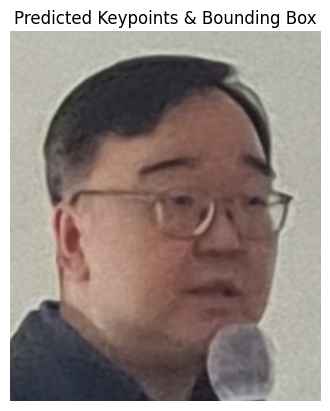

In [75]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# 모델 불러오기
model = YOLO("/content/runs/pose/face_kpt_finetune_v1/weights/best.pt")

# 테스트 이미지 경로
img_path = "/content/drive/MyDrive/test_image/스크린샷 2025-04-09 010148.png"

# confidence 낮춰서 예측
results = model(img_path, conf=0.1)

# 결과 가져오기
res = results[0]

# 예측된 객체가 하나도 없는 경우 확인
if not res.keypoints:  # keypoints가 비었는지 확인
    print("❗ 예측된 객체가 없습니다. confidence를 더 낮추거나, 이미지 상태를 확인하세요.")
else:
    # 시각화된 이미지 가져오기
    annotated_img = res.plot()

    # RGB 변환 후 출력
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Predicted Keypoints & Bounding Box")
    plt.show()


In [40]:
import os
from tqdm import tqdm

def expand_bbox(x_center, y_center, w, h, scale_w=1.0, scale_h=1.0):
    new_w = w * scale_w
    new_h = h * scale_h
    x_center = min(max(x_center, 0.0), 1.0)
    y_center = min(max(y_center, 0.0), 1.0)
    new_w = min(new_w, 1.0)
    new_h = min(new_h, 1.0)
    return x_center, y_center, new_w, new_h

def process_file(file_path, scale_w=1.0, scale_h=1.0):
    with open(file_path, 'r') as f:
        line = f.readline().strip()

    parts = line.split()
    if len(parts) < 5:
        return  # invalid label

    cls = parts[0]
    x_center, y_center, w, h = map(float, parts[1:5])
    keypoints = parts[5:]

    # 조정된 bbox 적용
    x_center, y_center, w, h = expand_bbox(x_center, y_center, w, h, scale_w, scale_h)

    # 라벨 다시 구성
    new_line = f"{cls} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f} " + " ".join(keypoints)

    # 저장
    with open(file_path, 'w') as f:
        f.write(new_line + "\n")

def process_folder(folder_path, scale_w=1.0, scale_h=1.0):
    label_dir = os.path.join(folder_path, 'labels')
    if not os.path.exists(label_dir):
        print(f"No labels directory in {folder_path}")
        return

    label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    for file_name in tqdm(label_files, desc=f"Processing {folder_path}"):
        file_path = os.path.join(label_dir, file_name)
        process_file(file_path, scale_w, scale_h)

# ⚙️ 여기에 train/val/test 경로 지정
base_paths = [
    "/content/drive/MyDrive/face_dataset02_yolo/train",
    "/content/drive/MyDrive/face_dataset02_yolo/val",
    "/content/drive/MyDrive/face_dataset02_yolo/test"
]

# ✨ 세로 늘리고, 가로 살짝 줄이기
for path in base_paths:
    process_folder(path, scale_w=0.9, scale_h=1.6)


Processing /content/drive/MyDrive/face_dataset02_yolo/train: 100%|██████████| 20/20 [00:00<00:00, 149.54it/s]
Processing /content/drive/MyDrive/face_dataset02_yolo/val: 100%|██████████| 20/20 [00:00<00:00, 148.80it/s]
Processing /content/drive/MyDrive/face_dataset02_yolo/test: 100%|██████████| 20/20 [00:00<00:00, 140.29it/s]


In [43]:
import os
import glob

def bbox_from_keypoints(keypoints, margin_x_ratio=0.2, margin_y_ratio=0.6):
    xs = [float(keypoints[i]) for i in range(0, len(keypoints), 3)]
    ys = [float(keypoints[i+1]) for i in range(0, len(keypoints), 3)]

    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)

    margin_x = (max_x - min_x) * margin_x_ratio
    margin_y = (max_y - min_y) * margin_y_ratio

    min_x = max(min_x - margin_x, 0)
    max_x = min(max_x + margin_x, 1)
    min_y = max(min_y - margin_y, 0)
    max_y = min(max_y + margin_y, 1)

    x_center = (min_x + max_x) / 2
    y_center = (min_y + max_y) / 2
    w = max_x - min_x
    h = max_y - min_y

    return x_center, y_center, w, h

def fix_yolo_keypoint_labels(label_dir):
    label_files = glob.glob(os.path.join(label_dir, "*.txt"))

    for file_path in label_files:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            parts = line.strip().split()
            cls = parts[0]
            keypoints = parts[5:]  # keypoints만
            xc, yc, w, h = bbox_from_keypoints(keypoints)
            new_line = f"{cls} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f} " + " ".join(keypoints)
            new_lines.append(new_line)

        with open(file_path, 'w') as f:
            f.write("\n".join(new_lines) + "\n")

# 이 경로들에 각각 적용
fix_yolo_keypoint_labels("/content/drive/MyDrive/face_dataset02_yolo/train/labels")
fix_yolo_keypoint_labels("/content/drive/MyDrive/face_dataset02_yolo/val/labels")
fix_yolo_keypoint_labels("/content/drive/MyDrive/face_dataset02_yolo/test/labels")


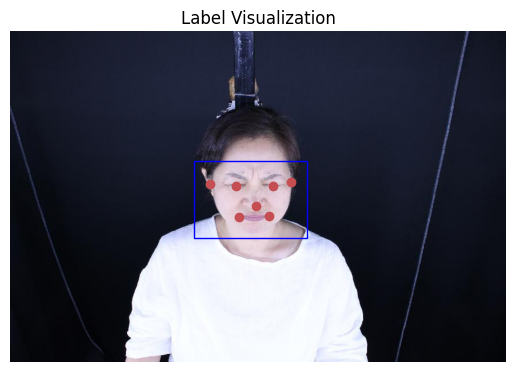

In [78]:
from PIL import Image
import matplotlib.pyplot as plt

# 이미지와 라벨 확인용
img_path = '/content/drive/MyDrive/face_dataset02_yolo/test/images/C16.jpg'
label_path = '/content/drive/MyDrive/face_dataset02_yolo/test/labels/C16.txt'

img = Image.open(img_path)
w, h = img.size

with open(label_path) as f:
    line = f.readline().strip().split()
    box = list(map(float, line[1:5]))
    kpts = list(map(float, line[5:]))

# 시각화
fig, ax = plt.subplots()
ax.imshow(img)

# 바운딩 박스 그리기
cx, cy, bw, bh = box[0]*w, box[1]*h, box[2]*w, box[3]*h
ax.add_patch(plt.Rectangle((cx - bw/2, cy - bh/2), bw, bh, edgecolor='blue', facecolor='none'))

# Keypoints 그리기
for i in range(0, len(kpts), 3):
    x, y, v = kpts[i]*w, kpts[i+1]*h, kpts[i+2]
    if v > 0:
        ax.plot(x, y, 'ro')

plt.title("Label Visualization")
plt.axis('off')
plt.show()


In [60]:
import os
import cv2
import albumentations as A
from tqdm import tqdm
import numpy as np
import shutil

# 원본 경로
origin_img_dir = "/content/drive/MyDrive/face_dataset02_yolo/train/images"
origin_lbl_dir = "/content/drive/MyDrive/face_dataset02_yolo/train/labels"

# 저장 경로
aug_img_dir = "/content/drive/MyDrive/face_dataset02_yolo/train/images_aug"
aug_lbl_dir = "/content/drive/MyDrive/face_dataset02_yolo/train/labels_aug"
os.makedirs(aug_img_dir, exist_ok=True)
os.makedirs(aug_lbl_dir, exist_ok=True)

# 증강기 정의 (랜덤 크롭, 회전, 밝기, 노이즈 등)
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=10, p=0.5),
    A.GaussNoise(p=0.2),
    A.MotionBlur(p=0.2),
    A.Affine(scale=(0.9, 1.1), translate_percent=0.05, rotate=(-10, 10), p=0.4)
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

# 증강 반복
for img_name in tqdm(os.listdir(origin_img_dir)):
    if not img_name.endswith(".jpg"): continue

    img_path = os.path.join(origin_img_dir, img_name)
    lbl_path = os.path.join(origin_lbl_dir, img_name.replace(".jpg", ".txt"))

    # 이미지 불러오기
    image = cv2.imread(img_path)
    h, w = image.shape[:2]

    # 라벨 로딩
    with open(lbl_path, "r") as f:
        line = f.readline().strip().split()
        cls_id = int(line[0])
        bbox = list(map(float, line[1:5]))
        keypoints_raw = list(map(float, line[5:]))
        keypoints = [(keypoints_raw[i] * w, keypoints_raw[i+1] * h) for i in range(0, len(keypoints_raw), 3)]

        # bbox 좌표 변환
        x_c, y_c, bw, bh = bbox
        x1 = (x_c - bw / 2) * w
        y1 = (y_c - bh / 2) * h
        x2 = (x_c + bw / 2) * w
        y2 = (y_c + bh / 2) * h

    # 증강 적용
    for i in range(2):  # 한 장당 2배 증강
        transformed = transform(image=image, keypoints=keypoints)
        img_aug = transformed["image"]
        kpts_aug = transformed["keypoints"]

        # 증강된 keypoint에서 bbox 재계산
        kpts_np = np.array(kpts_aug)
        min_x, min_y = np.min(kpts_np, axis=0)
        max_x, max_y = np.max(kpts_np, axis=0)

        bbox_aug = [
            ((min_x + max_x) / 2) / w,
            ((min_y + max_y) / 2) / h,
            (max_x - min_x) / w,
            (max_y - min_y) / h
        ]

        # keypoint 포맷 재변환
        kpt_out = []
        for x, y in kpts_aug:
            kpt_out.extend([x / w, y / h, 2.0])

        # 저장
        new_img_name = img_name.replace(".jpg", f"_aug{i}.jpg")
        new_lbl_name = new_img_name.replace(".jpg", ".txt")
        cv2.imwrite(os.path.join(aug_img_dir, new_img_name), img_aug)

        with open(os.path.join(aug_lbl_dir, new_lbl_name), "w") as f:
            f.write(f"{cls_id} {' '.join(map(str, bbox_aug))} {' '.join(map(str, kpt_out))}")

print("✅ 데이터 증강 완료!")

# 💡 증강된 데이터도 train/images, train/labels로 복사 (학습 시 자동 포함되게)
for f in os.listdir(aug_img_dir):
    shutil.copy(os.path.join(aug_img_dir, f), origin_img_dir)
for f in os.listdir(aug_lbl_dir):
    shutil.copy(os.path.join(aug_lbl_dir, f), origin_lbl_dir)

print("📁 증강 데이터 학습셋에 병합 완료!")


100%|██████████| 20/20 [00:01<00:00, 19.07it/s]


✅ 데이터 증강 완료!
📁 증강 데이터 학습셋에 병합 완료!


# 최종 학습 코드!!

In [79]:
import os

# YOLO keypoint label 폴더 경로
label_dir = '/content/drive/MyDrive/face_dataset02_yolo/test/labels'

# 조정값 (너가 원하는 범위로 조절 가능)
HEIGHT_SCALE = 1.3     # 높이 30% 증가
Y_SHIFT = -0.03        # 중심 y 위로 0.03 이동

# 수정 함수
def adjust_yolo_keypoint_bbox(line):
    parts = line.strip().split()
    if len(parts) < 6:
        return line  # 포맷 이상한 건 그대로 둠

    class_id = parts[0]
    x_center = float(parts[1])
    y_center = float(parts[2])
    width = float(parts[3])
    height = float(parts[4])

    # 바운딩박스 조정
    new_height = min(height * HEIGHT_SCALE, 1.0)
    new_y_center = max(min(y_center + Y_SHIFT, 1.0), 0.0)

    # 그대로 붙이기
    new_parts = [class_id, f"{x_center:.6f}", f"{new_y_center:.6f}", f"{width:.6f}", f"{new_height:.6f}"]
    new_parts += parts[5:]  # keypoints는 그대로

    return ' '.join(new_parts)

# 폴더 내 모든 .txt 파일 수정
for filename in os.listdir(label_dir):
    if filename.endswith('.txt'):
        file_path = os.path.join(label_dir, filename)

        with open(file_path, 'r') as f:
            lines = f.readlines()

        new_lines = [adjust_yolo_keypoint_bbox(line) for line in lines]

        with open(file_path, 'w') as f:
            f.write('\n'.join(new_lines) + '\n')

print("✅ 모든 라벨 파일의 바운딩박스가 조정되었습니다.")


✅ 모든 라벨 파일의 바운딩박스가 조정되었습니다.


In [80]:
from ultralytics import YOLO

# ✅ 사전학습된 모델 로드
model = YOLO("yolov8s-pose.pt")

# ✅ 학습 시작
model.train(
    data="/content/drive/MyDrive/face_dataset02_yolo/dataset.yaml",  # dataset.yaml 경로
    epochs=200,
    imgsz=640,
    batch=16,
    device=0,
    workers=2,
    name="face_kpt_finetune_v1",
    project="runs/pose",
    optimizer="SGD",
    lr0=0.005,
    lrf=0.01,
    warmup_epochs=5,
    weight_decay=0.0001,
    close_mosaic=5,
    seed=42,
    deterministic=True,
    val=True,
    verbose=True,
    plots=True,
    save=True,
    save_period=10
)


Ultralytics 8.3.104 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: task=pose, mode=train, model=yolov8s-pose.pt, data=/content/drive/MyDrive/face_dataset02_yolo/dataset.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=10, cache=False, device=0, workers=2, project=runs/pose, name=face_kpt_finetune_v12, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=5, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop

train: Scanning /content/drive/MyDrive/face_dataset02_yolo/train/labels.cache... 60 images, 0 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<?, ?it/s]

WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/face_dataset02_yolo/val/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]


Plotting labels to runs/pose/face_kpt_finetune_v12/labels.jpg... 
optimizer: SGD(lr=0.005, momentum=0.937) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0001), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/pose/face_kpt_finetune_v12
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/200      3.92G      3.865      8.579       0.72      7.549      3.949         25        640: 100%|██████████| 4/4 [00:01<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/200      3.92G      3.966      8.682      0.727      7.762      4.015         23        640: 100%|██████████| 4/4 [00:00<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         20         20          0          0          0          0          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/200      3.92G       3.52      8.587     0.7333      5.876      3.397         18        640: 100%|██████████| 4/4 [00:00<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         20         20     0.0236        0.9      0.133     0.0199          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/200      3.92G      2.779      7.824      0.739      3.018      2.854         31        640: 100%|██████████| 4/4 [00:00<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         20         20      0.386       0.25      0.296      0.104          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/200      3.92G       2.51      7.696     0.7167      2.444      2.549         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         20         20      0.603        0.6      0.648      0.351          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/200      3.92G      2.269      7.735      0.706      2.332      2.311         30        640: 100%|██████████| 4/4 [00:00<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         20         20      0.753       0.85       0.82      0.449          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/200      3.92G      2.181      7.031      0.696      1.984      2.262         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]

                   all         20         20      0.687       0.66      0.711      0.206          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/200      3.92G      2.059      7.308     0.7121      1.885      2.226         29        640: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]

                   all         20         20      0.805       0.85      0.902      0.328          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/200      3.92G       1.95      6.598     0.7037      1.836      2.189         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         20         20      0.669       0.55      0.569      0.189          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/200      3.92G      1.821      6.562      0.691      1.886      2.075         20        640: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         20         20      0.661      0.488      0.563      0.272          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/200      3.92G      1.725       6.22     0.7058      1.858      1.938         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         20         20       0.65      0.835      0.829       0.37          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/200      3.92G      1.791      6.313     0.7284      1.673      1.886         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


                   all         20         20      0.573       0.85      0.736      0.417          0          0          0          0

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/200      3.92G      1.549      6.082     0.6874      1.553      1.727         20        640: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         20         20      0.944       0.95      0.976      0.534          0          0          0          0



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/200      3.92G      1.596      5.851     0.7119       1.53      1.791         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         20         20       0.82        0.9       0.97      0.612     0.0367       0.05    0.00262   0.000262



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/200      3.92G      1.633      5.828     0.6964      1.451      1.762         19        640: 100%|██████████| 4/4 [00:00<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20         20      0.829       0.95      0.953      0.512      0.048       0.05    0.00554   0.000554



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/200      3.92G      1.725      5.423     0.7066      1.536      1.823         27        640: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20         20      0.634          1      0.773      0.336     0.0924       0.15     0.0264    0.00264



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/200      3.94G      1.633      5.755      0.705      1.542      1.776         18        640: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]

                   all         20         20      0.747       0.74      0.804       0.39     0.0928      0.169     0.0341    0.00372



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/200      3.94G      1.474      5.291     0.7024      1.515      1.645         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         20         20       0.44       0.95      0.479      0.249      0.184        0.4     0.0903     0.0162



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/200      3.94G       1.45      5.293     0.6712      1.436      1.597         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all         20         20      0.462          1       0.48      0.226      0.216        0.5      0.147     0.0227



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.96G      1.518      5.569      0.689      1.442      1.604         27        640: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         20         20      0.547       0.65      0.754      0.351      0.333        0.8      0.394     0.0558



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/200      3.96G      1.384      5.181     0.6696      1.379      1.552         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         20         20      0.538        0.9      0.745       0.36      0.449       0.75      0.522      0.127



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/200      3.96G      1.347      5.105     0.6846      1.418      1.514         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         20         20      0.888       0.85      0.931       0.45      0.545      0.539      0.442      0.157



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/200      3.96G      1.342      4.908     0.6585      1.326      1.527         20        640: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         20         20       0.82       0.85      0.929      0.483       0.82       0.85      0.929      0.338



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/200      3.99G      1.432      5.015     0.6847      1.372       1.56         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         20         20      0.736        0.8      0.911      0.475      0.736        0.8      0.915      0.297



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/200      3.99G      1.237      4.683     0.6702      1.296       1.42         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.96it/s]

                   all         20         20      0.988       0.85       0.96      0.566      0.988       0.85       0.96      0.404



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/200      3.99G      1.193      4.675     0.6532      1.247      1.396         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         20         20      0.809        0.7      0.872      0.428      0.827      0.716      0.877      0.364



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/200      3.99G      1.272       4.79     0.6526      1.321      1.443         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20         20      0.473          1      0.572       0.29      0.566      0.911      0.737      0.286



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/200      4.01G       1.29      4.472     0.6398      1.335      1.441         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         20         20      0.667       0.85      0.855      0.406      0.739      0.848      0.903      0.385



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/200      4.01G      1.175      3.816     0.6492      1.249      1.382         28        640: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         20         20      0.922       0.95      0.978      0.578      0.922       0.95      0.978      0.459



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/200      4.01G      1.168      4.331     0.6481      1.244      1.393         18        640: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         20         20      0.947      0.886      0.951      0.392      0.917       0.95       0.97      0.441



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/200      4.01G      1.136      4.117     0.6225      1.285      1.337         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         20         20      0.629       0.75      0.785       0.36      0.496        0.9      0.725      0.342



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/200      4.04G      1.103      4.186     0.6275      1.227      1.296         20        640: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         20         20      0.941        0.9      0.942      0.603      0.829      0.967      0.932      0.362



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/200      4.04G      1.124        4.2      0.658      1.165      1.355         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         20         20      0.766       0.85      0.861      0.424      0.766       0.85      0.862       0.44



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/200      4.04G     0.9455      4.255     0.6315      1.149      1.236         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         20         20      0.926       0.75      0.922      0.514      0.658       0.65       0.71      0.332



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/200      4.04G      1.008      4.092     0.6374      1.201      1.241         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.37it/s]

                   all         20         20      0.496          1      0.711      0.424      0.486      0.993      0.708       0.24



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/200      4.06G      1.061      3.692     0.6202      1.179      1.268         19        640: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]

                   all         20         20      0.487          1      0.762      0.388      0.529          1      0.778      0.406



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/200      4.06G     0.9584      3.801     0.5993      1.096      1.222         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

                   all         20         20      0.952      0.999       0.99      0.498      0.952      0.999       0.99      0.478



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/200      4.06G      1.003      3.596     0.6051      1.093      1.286         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         20         20      0.915        0.9      0.971      0.582      0.811        0.8      0.808      0.305



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/200      4.06G     0.9855      3.743      0.588      1.148      1.251         30        640: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20         20      0.497          1      0.751       0.52      0.463      0.949      0.635      0.269



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/200      4.06G     0.8708      3.658     0.5685      1.054      1.183         20        640: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]

                   all         20         20      0.816       0.95      0.954      0.583      0.725       0.85      0.832      0.355



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/200      4.06G     0.8347      3.564     0.6063      1.121      1.147         19        640: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         20         20      0.483          1      0.485      0.283      0.461       0.95      0.545       0.21



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/200      4.06G     0.8835      3.541      0.532      1.131      1.164         18        640: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         20         20      0.833          1      0.932      0.467      0.832      0.993      0.936       0.47



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/200      4.06G     0.9866       3.72     0.5669      1.044      1.248         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         20         20      0.953       0.95      0.988      0.619      0.898        0.9      0.917       0.28



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/200      4.06G     0.8857      3.439     0.5638      1.031      1.188         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         20         20      0.849          1      0.979      0.468          1      0.975      0.995      0.494



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/200      4.06G     0.8198      3.097     0.5433      1.031       1.14         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         20         20      0.927       0.85      0.955      0.613      0.862        0.8      0.837      0.348



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/200      4.06G     0.8717      3.228     0.5706      1.072      1.134         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         20         20      0.897       0.85      0.955      0.526      0.786        0.8      0.887      0.379



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/200      4.06G     0.7796      3.437     0.5704      1.028      1.096         30        640: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         20         20      0.956        0.8      0.938      0.555      0.888       0.75      0.866      0.415



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/200      4.06G     0.7755       3.11     0.5802      1.004      1.082         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         20         20      0.975        0.8      0.929      0.504      0.924       0.75        0.9      0.441



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/200      4.06G     0.7597      3.458     0.5322     0.9859      1.072         18        640: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         20         20      0.994          1      0.995      0.473      0.944       0.95      0.962      0.542



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/200      4.06G     0.7869      3.051     0.5103      0.938      1.076         27        640: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         20         20      0.994          1      0.995      0.555      0.944       0.95       0.96      0.542



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/200      4.06G     0.8826      2.805     0.5484      1.175      1.165         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         20         20      0.944        0.7      0.893      0.564      0.755      0.772      0.874      0.437



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/200      4.06G     0.8189       2.76     0.5044      1.026      1.081         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.23it/s]

                   all         20         20      0.646       0.75      0.848      0.389      0.726       0.85      0.829      0.376



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/200      4.06G     0.8596      3.418      0.563      1.052      1.151         29        640: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         20         20      0.672       0.85      0.857      0.543      0.713        0.9      0.851      0.278



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/200      4.06G     0.7787      3.048      0.525     0.9413      1.112         20        640: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         20         20      0.968        0.9      0.972      0.502      0.896      0.864      0.879      0.405



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/200      4.06G     0.7682      2.886     0.4889     0.9674      1.093         19        640: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         20         20       0.81      0.852      0.914      0.609      0.862      0.936      0.908      0.445



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/200      4.06G     0.7754      2.398     0.5029      1.005      1.073         32        640: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         20         20      0.719        0.9      0.859      0.455      0.666        0.9      0.795      0.365



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/200      4.06G     0.8166      3.007     0.4968     0.9644      1.093         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20         20      0.774      0.857      0.937        0.5      0.781      0.889      0.907      0.387



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/200      4.06G     0.6641      2.686     0.4604     0.9378     0.9906         28        640: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         20         20      0.533          1      0.577      0.326      0.474          1      0.571      0.216



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/200      4.06G       0.73      2.962     0.4936     0.9562      1.041         19        640: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         20         20      0.576       0.95      0.748      0.398        0.6        0.8      0.773      0.417



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/200      4.06G     0.7165      2.964     0.4957     0.9722      1.043         28        640: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         20         20      0.661        0.9       0.79      0.459      0.473          1      0.552      0.216



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/200      4.06G     0.7384      2.785     0.4959     0.9108      1.077         28        640: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         20         20      0.607      0.928      0.742      0.369      0.607      0.928      0.808      0.507



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/200      4.06G     0.7044      2.537     0.5119      0.958      1.054         31        640: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         20         20      0.696       0.85      0.793        0.5      0.696       0.85      0.789      0.339



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/200      4.06G     0.7388      2.574     0.4283     0.8891      1.052         31        640: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         20         20      0.821      0.918      0.932      0.447      0.804        0.9      0.864      0.403



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/200      4.06G     0.7057      2.331      0.481     0.9479      1.037         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.99it/s]

                   all         20         20      0.661       0.85      0.782      0.447      0.628        0.8       0.66      0.363



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/200      4.06G     0.7116      2.613     0.4975     0.8809      1.032         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         20         20      0.832          1      0.953      0.511      0.697       0.75      0.648      0.299



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/200      4.06G     0.6782      2.432     0.4755     0.9206      1.025         17        640: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

                   all         20         20      0.794          1      0.888      0.512      0.764      0.809      0.744      0.352



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/200      4.06G     0.6632      2.493      0.492     0.8082      1.014         19        640: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]

                   all         20         20      0.866      0.968      0.928      0.503      0.687        0.8      0.692      0.387



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/200      4.06G     0.6339      2.263     0.4784     0.8818     0.9827         18        640: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         20         20       0.64       0.98      0.735      0.435      0.717        0.8      0.729      0.309



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/200      4.06G     0.6964       2.55     0.5155     0.8837      1.044         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         20         20      0.601          1      0.711      0.345      0.676        0.8      0.732      0.412



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/200      4.06G     0.7184      2.338     0.5563     0.9337       1.06         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         20         20      0.563        0.9      0.633      0.338      0.787        0.9      0.862      0.448



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/200      4.06G     0.6343      2.068     0.4651     0.8277     0.9823         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         20         20      0.578          1      0.661      0.382      0.587       0.75      0.655      0.373



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/200      4.06G     0.6161      2.117     0.4765     0.8237      1.006         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         20         20      0.563          1      0.624      0.344       0.67       0.75      0.726      0.395



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/200      4.06G      0.677      2.241     0.5315     0.8849      1.056         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]

                   all         20         20      0.526          1       0.54      0.334      0.618       0.85      0.788      0.336



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/200      4.06G     0.6639       2.21     0.4513     0.8275     0.9937         32        640: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.30it/s]

                   all         20         20      0.515          1      0.538      0.315      0.748       0.85      0.934        0.5



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/200      4.06G      0.604      1.941     0.4626     0.7896      1.004         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.80it/s]

                   all         20         20      0.517          1      0.525      0.322      0.774      0.856      0.871      0.501



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/200      4.06G     0.6339      1.991     0.4519     0.7952      1.001         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

                   all         20         20      0.513          1       0.56      0.294      0.895      0.852      0.898      0.616



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/200      4.06G     0.7051      2.382     0.5484     0.8605      1.043         21        640: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         20         20      0.516          1      0.558      0.329      0.919       0.85      0.893      0.498



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/200      4.06G     0.5751      2.063     0.4381     0.8356     0.9751         29        640: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all         20         20      0.476          1       0.51      0.272      0.846          1      0.968      0.554



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/200      4.06G     0.5609      2.006     0.4491     0.7873     0.9865         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         20         20      0.484          1      0.506      0.305      0.931       0.85      0.931      0.559



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/200      4.06G     0.6143      1.791     0.4795     0.8515      0.986         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

                   all         20         20      0.484          1      0.523      0.275      0.966       0.85       0.97      0.647



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/200      4.06G     0.5667      1.697     0.4416      0.823     0.9758         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20         20      0.486          1      0.497      0.299      0.883       0.95      0.955      0.639



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/200      4.06G     0.6041      1.754     0.4892      0.793     0.9853         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         20         20       0.51      0.988       0.51      0.291      0.804      0.823      0.872      0.586



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/200      4.06G     0.5838      1.675     0.4627     0.7638     0.9973         18        640: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20         20      0.522          1       0.53      0.288      0.755       0.85      0.914        0.6



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/200      4.06G     0.6231      2.296     0.5162     0.7664       1.01         15        640: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         20         20      0.531      0.962      0.601      0.322      0.779       0.95      0.938      0.672



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/200      4.06G     0.6118      1.895     0.4942     0.8367     0.9858         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         20         20      0.527          1      0.574      0.322      0.794        0.9      0.941      0.607



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/200      4.06G      0.655      1.783      0.468      0.761      1.013         19        640: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]

                   all         20         20      0.752        0.8       0.77      0.417      0.889       0.95      0.988      0.692



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/200      4.06G     0.6183      1.564     0.4267      0.768     0.9794         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         20         20      0.511          1      0.524      0.301      0.701       0.95       0.93      0.662



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/200      4.06G     0.5402       1.65     0.4263     0.7042     0.9345         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         20         20      0.495          1      0.497       0.27      0.855       0.85      0.951      0.745



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/200      4.06G     0.5126      1.733     0.4528     0.7432     0.9173         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         20         20      0.508          1       0.51      0.289      0.895      0.854      0.934       0.62



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/200      4.06G     0.6083       1.97     0.4926     0.7795     0.9814         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

                   all         20         20      0.507          1       0.51      0.273      0.894       0.75      0.892      0.642



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/200      4.06G     0.5693      1.429     0.4629     0.7765     0.9789         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         20         20      0.493          1      0.497      0.258      0.862      0.934      0.956      0.699



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/200      4.06G     0.5658       1.68     0.4643     0.7285     0.9689         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         20         20      0.508          1      0.511      0.273      0.821      0.919      0.906      0.651



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/200      4.06G     0.5709      1.801     0.4555     0.7123     0.9724         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         20         20       0.51          1      0.524      0.307      0.845        0.8      0.944      0.682



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/200      4.06G     0.5797      1.491      0.472     0.6955       0.96         20        640: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20         20      0.499      0.996      0.497      0.244      0.896      0.862      0.939      0.713



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/200      4.06G     0.5681      1.569     0.4576     0.6706     0.9725         19        640: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         20         20      0.486          1      0.485      0.273      0.863        0.8      0.931      0.726



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/200      4.06G     0.5666      1.696     0.4543     0.6826     0.9381         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20         20      0.496          1      0.497      0.247      0.938        0.9      0.972      0.748



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/200      4.06G     0.6142      1.653     0.5309     0.7559      1.016         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         20         20      0.483          1      0.485       0.28      0.948      0.913      0.986      0.757



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/200      4.06G     0.5988      1.665     0.5153     0.7261     0.9843         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         20         20      0.486      0.992      0.485      0.263      0.933       0.95      0.981       0.74



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/200      4.06G     0.5909      1.609     0.4759     0.7281     0.9942         29        640: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         20         20      0.487          1      0.485      0.255       0.86       0.85      0.949      0.775



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/200      4.06G     0.5193       1.32     0.4895     0.6738     0.9431         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all         20         20      0.485      0.987      0.485      0.252      0.991        0.9      0.982      0.805



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/200      4.06G      0.573      1.402     0.5218     0.7339     0.9825         14        640: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         20         20      0.485      0.989      0.485      0.275      0.785        0.9      0.876      0.716



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/200      4.06G     0.5437      1.341     0.4615     0.6569     0.9549         20        640: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         20         20      0.482      0.976      0.485       0.26       0.94       0.85      0.899      0.736



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/200      4.06G     0.5536      1.666     0.4413     0.6715     0.9552         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

                   all         20         20      0.496      0.986      0.497       0.26      0.949          1      0.995      0.811



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/200      4.06G     0.5619       1.56     0.5445     0.6865     0.9663         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         20         20      0.472      0.937      0.472      0.245      0.905      0.955       0.98      0.807



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/200      4.06G     0.5748      1.479     0.4341     0.7302     0.9643         34        640: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         20         20      0.472      0.937      0.474      0.267      0.902          1      0.988      0.831



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/200      4.06G     0.5466      1.255      0.421     0.6576     0.9422         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         20         20      0.493      0.974      0.497      0.258          1       0.89      0.982       0.81



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/200      4.06G     0.5838      1.503     0.4802     0.6073     0.9873         20        640: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         20         20      0.471      0.936      0.485       0.29          1      0.842      0.973       0.78



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/200      4.06G     0.5236      1.424     0.4481     0.6596     0.9673         18        640: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         20         20      0.473      0.944      0.485      0.265      0.889       0.95      0.977      0.793



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/200      4.06G     0.4863      1.389     0.4221     0.6531     0.9531         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         20         20       0.47      0.933      0.485      0.263      0.988       0.95      0.987      0.786



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/200      4.06G     0.5149      1.268     0.4612     0.6506     0.9387         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.03it/s]

                   all         20         20       0.49       0.96      0.497      0.255       0.95       0.95      0.988      0.786



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/200      4.06G     0.5281      1.271     0.4532     0.6295     0.9261         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]

                   all         20         20      0.481      0.974      0.485      0.277      0.902        0.9      0.982      0.779



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/200      4.06G     0.5048      1.488     0.4637     0.6357     0.9447         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         20         20      0.468        0.9      0.485      0.279      0.995       0.95      0.988      0.726



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/200      4.06G     0.5005      1.172     0.3819     0.6186     0.9178         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20         20      0.474        0.9      0.497      0.277      0.994       0.95      0.985      0.747



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/200      4.06G     0.5228      1.298     0.4253      0.671     0.9372         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         20         20       0.47      0.888      0.497      0.261      0.988       0.95      0.982       0.76



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/200      4.06G     0.5017      1.232     0.4332     0.6177     0.9041         29        640: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         20         20      0.482       0.93      0.497      0.274       0.95      0.944      0.976      0.796



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/200      4.06G     0.4871      1.355      0.454     0.6226     0.9217         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         20         20      0.463      0.862      0.497      0.279      0.995       0.95      0.988      0.822



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    117/200      4.06G      0.532       1.38     0.5056     0.6501     0.9475         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.02it/s]

                   all         20         20      0.458      0.846      0.485      0.279          1      0.994      0.995      0.819



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    118/200      4.06G     0.5562      1.651     0.5077     0.6121     0.9554         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         20         20      0.496          1      0.497      0.277          1      0.893      0.976      0.805



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    119/200      4.06G     0.5144      1.088     0.4441     0.6478     0.9522         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         20         20      0.473      0.896      0.497      0.301       0.95      0.942      0.975      0.832



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    120/200      4.06G     0.4895       1.25     0.4354      0.577     0.9302         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         20         20      0.456       0.84       0.47      0.266       0.99       0.95      0.988       0.82



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    121/200      4.06G        0.5      1.157     0.4477     0.5801      0.924         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         20         20       0.47      0.889      0.472      0.257      0.989       0.95      0.988      0.775



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    122/200      4.06G     0.4749      1.148     0.3889     0.6032     0.9056         28        640: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

                   all         20         20      0.468      0.881      0.471      0.249      0.991       0.95       0.99      0.803



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    123/200      4.06G     0.5281      1.102     0.4615     0.5977     0.9492         18        640: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.93it/s]

                   all         20         20      0.418      0.755      0.444      0.253          1          1      0.995      0.784



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    124/200      4.06G     0.4928      1.085     0.4788     0.6043     0.9359         29        640: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]

                   all         20         20      0.439      0.784      0.458      0.269          1      0.998      0.995      0.802



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    125/200      4.06G     0.4876      1.245     0.4421     0.5788     0.9328         32        640: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         20         20      0.457      0.841      0.481      0.265          1      0.943      0.985      0.801



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    126/200      4.06G     0.4691      1.028     0.4018     0.6141     0.8983         19        640: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.21it/s]

                   all         20         20       0.46      0.851       0.48      0.275      0.943       0.95      0.987      0.788



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    127/200      4.06G     0.4716      1.322     0.4275     0.5586     0.9482         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         20         20      0.458      0.846      0.481      0.278      0.908      0.989      0.988        0.8



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    128/200      4.06G     0.4827      1.462     0.4868     0.5682     0.9338         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         20         20      0.458      0.845      0.483      0.277      0.933       0.95       0.99      0.812



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    129/200      4.06G     0.4927      1.182     0.4972     0.6206     0.9459         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         20         20      0.458      0.845      0.484      0.283      0.866          1       0.97      0.776



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    130/200      4.06G     0.4328      1.248     0.4207     0.6208     0.9037         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         20         20      0.452      0.827      0.481      0.279      0.952      0.991      0.981      0.792



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    131/200      4.06G     0.4859      1.053     0.4852      0.638     0.9406         18        640: 100%|██████████| 4/4 [00:00<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]

                   all         20         20      0.455      0.835      0.483      0.281      0.941       0.95      0.968      0.794



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    132/200      4.06G     0.4742      1.094     0.4384     0.5731     0.9187         27        640: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         20         20      0.447       0.81      0.459      0.263      0.942       0.95      0.978      0.787



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    133/200      4.06G      0.431      1.028     0.3714     0.5343     0.8955         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all         20         20      0.442      0.792       0.47       0.27      0.952      0.993      0.981      0.817



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    134/200      4.06G     0.5018      1.017     0.5577     0.6102     0.9385         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         20         20      0.428      0.787      0.443      0.252      0.952          1      0.988      0.809



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    135/200      4.06G     0.4509      1.162     0.4469     0.5866     0.9193         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         20         20      0.455      0.834      0.484      0.263      0.935          1      0.983      0.791



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    136/200      4.06G     0.4682      1.139     0.4692     0.5538     0.9174         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         20         20      0.433        0.8      0.471      0.259      0.948          1      0.981      0.825



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    137/200      4.06G     0.4322      1.084     0.4723     0.5223     0.8987         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

                   all         20         20      0.437        0.8      0.461      0.252      0.889       0.95      0.971      0.794



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    138/200      4.06G     0.4804      1.226     0.4753     0.5721     0.9169         14        640: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         20         20      0.437      0.814      0.459       0.27      0.946      0.883      0.977      0.792



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    139/200      4.06G     0.4649     0.9912     0.4487     0.5983     0.9044         18        640: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         20         20      0.453      0.829      0.472      0.268      0.848          1      0.976       0.79



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    140/200      4.06G     0.4364      1.003     0.4334     0.5496     0.8964         28        640: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

                   all         20         20      0.456      0.838      0.474      0.278      0.949      0.937      0.978      0.818



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    141/200      4.06G     0.4117     0.8614     0.3795     0.4918     0.8927         28        640: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         20         20      0.454       0.85      0.485      0.274      0.943       0.85      0.957      0.812



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    142/200      4.06G     0.4476      0.941     0.4302     0.5294     0.9182         29        640: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         20         20      0.465      0.869      0.485       0.28      0.944      0.836      0.957      0.811



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    143/200      4.06G     0.4294      1.014     0.4268     0.4686     0.9177         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]

                   all         20         20       0.47      0.887      0.497      0.276      0.896       0.86      0.955      0.808



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    144/200      4.06G     0.4545      1.016     0.4312     0.5572     0.9188         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]

                   all         20         20      0.466       0.85      0.497      0.276      0.902      0.916      0.978      0.811



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    145/200      4.06G     0.4031      1.032     0.4234     0.4653     0.8663         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         20         20      0.457       0.85      0.468       0.26      0.938          1       0.99      0.813



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    146/200      4.06G      0.444       1.04     0.4456     0.5248     0.9288         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.43it/s]

                   all         20         20      0.364          1      0.463      0.261      0.996       0.95      0.988      0.829



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    147/200      4.06G     0.4379     0.8843     0.4806     0.5393     0.9101         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         20         20      0.364          1      0.463      0.261          1      0.981      0.995      0.838



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    148/200      4.06G     0.4178     0.9999     0.4183     0.4707     0.9023         30        640: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

                   all         20         20      0.385          1      0.463      0.264          1      0.986      0.995      0.834



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    149/200      4.06G     0.4286     0.9634     0.4553     0.4907     0.8932         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         20         20      0.385          1      0.459      0.265      0.989          1      0.995      0.854



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    150/200      4.06G     0.4705     0.9509     0.4462     0.5212     0.9287         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         20         20      0.377          1      0.463       0.27      0.992          1      0.995      0.883



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    151/200      4.06G     0.4853       1.09     0.4677     0.5249     0.9286         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.33it/s]

                   all         20         20      0.385          1      0.463      0.267      0.994          1      0.995      0.876



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    152/200      4.06G     0.4804      1.028     0.4753     0.5051     0.9133         35        640: 100%|██████████| 4/4 [00:00<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         20         20      0.392          1      0.432      0.247      0.997          1      0.995      0.864



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    153/200      4.06G     0.4104     0.9094     0.3649      0.518     0.9011         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         20         20      0.385          1      0.445      0.254          1      0.987      0.995      0.874



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    154/200      4.06G     0.4218     0.9436     0.4215     0.5111     0.9021         33        640: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         20         20      0.377          1      0.447      0.254       0.93       0.95      0.981      0.864



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    155/200      4.06G     0.3934     0.7582     0.3931     0.4721     0.8895         30        640: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         20         20       0.37          1      0.445       0.26      0.932       0.95       0.98      0.861



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    156/200      4.06G     0.4801       1.23     0.5133     0.5117     0.9264         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all         20         20       0.37          1      0.443      0.261      0.951      0.981      0.988      0.855



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    157/200      4.06G     0.4116     0.9698     0.3974     0.4838      0.889         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         20         20      0.365       0.95      0.423      0.245      0.948          1      0.993      0.854



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    158/200      4.06G     0.4341      1.096     0.4874     0.5209     0.9302         28        640: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]

                   all         20         20      0.358       0.95      0.427      0.245      0.947          1       0.99      0.856



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    159/200      4.06G     0.4708       1.22     0.4871     0.5551     0.9321         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         20         20       0.38       0.95      0.431      0.246      0.949          1      0.993      0.867



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    160/200      4.06G     0.4172     0.9353      0.386     0.4781     0.8932         33        640: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20         20      0.365       0.95      0.441      0.256      0.979       0.95       0.99      0.868



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    161/200      4.06G      0.432     0.9675     0.4231     0.4637     0.8901         34        640: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         20         20      0.351          1      0.441      0.254      0.949      0.922      0.986      0.859



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    162/200      4.06G      0.419     0.8746     0.4716     0.5292     0.8884         31        640: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

                   all         20         20      0.345          1      0.429       0.24      0.949      0.924      0.986      0.851



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    163/200      4.06G     0.4066     0.8037     0.4305     0.4384     0.8835         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]

                   all         20         20      0.364          1      0.431      0.246      0.927       0.95      0.983      0.855



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    164/200      4.06G     0.3728     0.9107     0.4444     0.4829     0.8732         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.88it/s]

                   all         20         20      0.352       0.95      0.422       0.24      0.965       0.95       0.99      0.861



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    165/200      4.06G     0.4114     0.9343     0.4664     0.4935     0.9256         32        640: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         20         20      0.364          1      0.443      0.256      0.901          1      0.985      0.848



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    166/200      4.06G     0.4123     0.7965      0.416     0.5157     0.9161         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         20         20      0.385          1      0.452      0.259       0.95          1       0.99      0.861



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    167/200      4.06G     0.3798     0.6346     0.4108     0.4539     0.8877         29        640: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         20         20      0.385          1      0.463       0.26      0.952      0.986       0.99      0.866



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    168/200      4.06G     0.4026     0.8647     0.4742     0.4742     0.8989         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         20         20      0.408          1      0.474      0.269      0.942          1      0.983      0.836



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    169/200      4.06G     0.3802     0.9805     0.5023     0.5118     0.9023         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         20         20      0.377          1      0.463      0.259      0.907          1      0.988      0.838



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    170/200      4.06G      0.372     0.8196     0.4195     0.4769     0.8737         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         20         20      0.392          1      0.459      0.263      0.942          1      0.995      0.857



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    171/200      4.06G      0.388     0.8601     0.3899     0.5126     0.8838         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         20         20      0.392          1      0.458      0.259      0.922          1      0.993      0.866



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    172/200      4.06G      0.362     0.7301     0.3566     0.4496     0.8751         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         20         20      0.392          1      0.446      0.259      0.906       0.95      0.988      0.857



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    173/200      4.06G     0.3888      0.832     0.4238     0.5029     0.8686         20        640: 100%|██████████| 4/4 [00:00<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         20         20       0.38       0.95      0.436      0.255      0.959       0.85      0.982      0.865



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    174/200      4.06G     0.3741     0.7153     0.4263     0.4754     0.8811         25        640: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

                   all         20         20      0.396       0.95      0.447      0.262      0.995        0.9      0.984      0.867



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    175/200      4.06G     0.3694     0.7685     0.4683     0.4843     0.8753         28        640: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         20         20      0.396       0.95      0.447      0.262      0.975       0.85      0.982      0.852



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    176/200      4.06G     0.3971     0.7941     0.4545     0.5131     0.9203         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         20         20      0.408          1      0.456      0.257          1      0.875      0.984      0.859



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    177/200      4.06G     0.3773     0.7115     0.4172     0.4421     0.8921         31        640: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         20         20      0.392          1      0.459      0.254      0.865      0.962      0.988      0.859



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    178/200      4.06G     0.4313      0.927     0.4679     0.5116     0.9213         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         20         20      0.392          1      0.469      0.263      0.842       0.95      0.972      0.845



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    179/200      4.06G     0.3784     0.8992     0.4094     0.4805     0.8862         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]

                   all         20         20      0.388       0.95      0.447      0.259       0.97       0.85      0.976      0.853



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    180/200      4.06G     0.3674     0.7918     0.4327     0.4649     0.8605         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.26it/s]

                   all         20         20      0.388       0.95      0.461      0.265          1      0.887      0.982      0.862



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    181/200      4.06G     0.3836     0.7092     0.4329     0.4641     0.8755         20        640: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.89it/s]

                   all         20         20      0.413       0.95      0.448      0.259          1      0.931       0.99       0.87



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    182/200      4.06G     0.3241      0.784     0.3811     0.4148     0.8565         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         20         20      0.404       0.95      0.448      0.258      0.996       0.95      0.993      0.879



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    183/200      4.06G      0.372     0.7393     0.4317     0.4441     0.8733         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.05it/s]

                   all         20         20      0.422       0.95      0.437      0.251          1      0.992      0.995      0.889



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    184/200      4.06G     0.3687     0.9206     0.4105     0.4507     0.8847         23        640: 100%|██████████| 4/4 [00:00<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         20         20      0.422       0.95      0.437      0.255      0.988          1      0.995       0.89



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    185/200      4.06G     0.3684     0.7095     0.4186     0.4587     0.8856         29        640: 100%|██████████| 4/4 [00:00<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         20         20      0.413       0.95      0.436      0.248          1      0.959      0.995       0.88



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    186/200      4.06G     0.3763      0.805      0.417     0.4312     0.8796         20        640: 100%|██████████| 4/4 [00:00<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]

                   all         20         20      0.391        0.9      0.421       0.24      0.927          1       0.99      0.884



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    187/200      4.06G     0.3809     0.7314     0.4138     0.4618     0.8733         21        640: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

                   all         20         20      0.391        0.9      0.435      0.248      0.893          1      0.986       0.88



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    188/200      4.06G     0.3603     0.6323     0.4417     0.4527     0.8497         29        640: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]

                   all         20         20      0.391        0.9      0.421      0.243      0.892          1      0.981      0.876



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    189/200      4.06G     0.3405     0.6766     0.4305     0.4323     0.8682         24        640: 100%|██████████| 4/4 [00:00<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         20         20        0.4        0.9       0.42       0.24      0.889          1      0.978      0.871



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    190/200      4.06G     0.4239     0.9447     0.5453     0.5503     0.9217         27        640: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         20         20      0.383        0.9      0.418      0.232      0.895          1      0.978      0.871



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    191/200      4.06G     0.3726       0.82     0.4315     0.4302     0.8839         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]

                   all         20         20       0.37       0.85      0.408      0.228      0.894          1      0.978      0.861



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    192/200      4.06G     0.3826     0.8953     0.4943     0.4664     0.9106         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         20         20       0.37       0.85      0.408       0.23      0.891          1      0.978      0.853



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    193/200      4.06G      0.396     0.8931     0.4051     0.4531     0.8766         22        640: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         20         20      0.378       0.85      0.408      0.234      0.905          1      0.978      0.854



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    194/200      4.06G     0.3775     0.7897     0.4784     0.4346     0.8971         26        640: 100%|██████████| 4/4 [00:00<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

                   all         20         20       0.37       0.85      0.408      0.234      0.904      0.947      0.978      0.851



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    195/200      4.06G     0.3441     0.7482     0.3945     0.4275     0.8689         29        640: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         20         20       0.37       0.85      0.408      0.236      0.933        0.9      0.974      0.837


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    196/200      4.06G     0.3356     0.4745     0.1545     0.4835     0.8453         12        640: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]

                   all         20         20       0.37       0.85      0.408      0.236       0.91        0.9      0.969      0.843



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    197/200      4.06G     0.2792     0.4657     0.1624      0.511     0.8103         12        640: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         20         20      0.378       0.85      0.408      0.242      0.909        0.9       0.97      0.846



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    198/200      4.06G     0.2931     0.4339     0.1649     0.5228     0.8586         12        640: 100%|██████████| 4/4 [00:00<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]

                   all         20         20       0.37       0.85      0.408      0.245      0.885        0.9      0.971      0.844



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    199/200      4.06G     0.2596     0.3759     0.1567     0.3698     0.8109         12        640: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]

                   all         20         20      0.378       0.85      0.408       0.25      0.832          1      0.974      0.844



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    200/200      4.06G     0.2622     0.4131     0.1559     0.3992     0.8111         12        640: 100%|██████████| 4/4 [00:00<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         20         20      0.416      0.747      0.406       0.25      0.867      0.978      0.974      0.851



200 epochs completed in 0.065 hours.
Optimizer stripped from runs/pose/face_kpt_finetune_v12/weights/last.pt, 23.1MB
Optimizer stripped from runs/pose/face_kpt_finetune_v12/weights/best.pt, 23.1MB

Validating runs/pose/face_kpt_finetune_v12/weights/best.pt...
Ultralytics 8.3.104 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv8s-pose summary (fused): 81 layers, 11,413,938 parameters, 0 gradients, 29.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]


                   all         20         20      0.377          1      0.463       0.27      0.992          1      0.995      0.883
Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/pose/face_kpt_finetune_v12


ultralytics.utils.metrics.PoseMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7af7a42ddb90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(P)', 'F1-Confidence(P)', 'Precision-Confidence(P)', 'Recall-Confidence(P)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    


image 1/1 /content/drive/MyDrive/test_image/img1.jpg: 640x512 1 face, 12.4ms
Speed: 3.1ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 512)


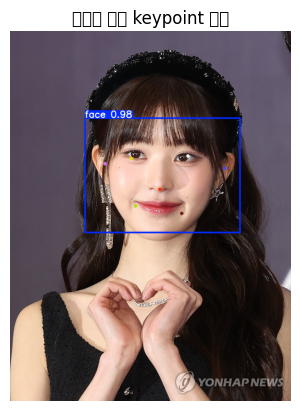

In [84]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

model = YOLO("runs/pose/face_kpt_finetune_v12/weights/best.pt")
img_path = "/content/drive/MyDrive/test_image/img1.jpg"  # 교수님 이미지 경로

results = model(img_path)
annotated_img = results[0].plot()

plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("교수님 얼굴 keypoint 예측")
plt.show()
